<a href="https://colab.research.google.com/github/i-osipchyk/grocery-sales/blob/main/albert_assignemnt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import zipfile
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Ingestion

Assumes that the archive is uploaded to Google Colab or other environment

In [3]:
task_archive = 'forecast-task.zip'

# Exctract archive
with zipfile.ZipFile(task_archive, 'r') as zip_ref:
    zip_ref.extractall()

In [207]:
# Import data
data = pd.read_csv('forecast-task/sales_data.csv')

# EDA

## Data Exploration

### Data Understanding

In [208]:
data.head()

Unnamed: 0  shop_id        date item_name  n_sold  price  promotion  \
0           0        1  2021-01-02  cucumber   367.0   8.50      False   
1           1        1  2021-01-02       bun   947.0   3.61      False   
2           2        1  2021-01-02     salad   459.0   9.90      False   
3           3        1  2021-01-02  baguette  1343.0   3.90      False   
4           4        1  2021-01-03  cucumber   391.0   8.50      False   

     category  
0  Vegetables  
1      Bakery  
2  Vegetables  
3      Bakery  
4  Vegetables

In [209]:
data.shape

(3229, 8)

In [210]:
data.dtypes

Unnamed: 0      int64
shop_id         int64
date           object
item_name      object
n_sold        float64
price         float64
promotion        bool
category       object
dtype: object

In [211]:
len(data.iloc[:, 0].unique())

3229

First column is the same as index, so I will drop it.

In [212]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [213]:
# Check format of the data
data.tail()

shop_id        date item_name  n_sold  price  promotion category
3224        2  2022-04-13  baguette  3245.0   4.50      False   Bakery
3225        2  2022-04-14       bun  3698.0   4.24      False   Bakery
3226        2  2022-04-14  baguette  3175.0   4.50      False   Bakery
3227        2  2022-04-15       bun  2051.0   4.18      False   Bakery
3228        2  2022-04-15  baguette  1927.0   4.50      False   Bakery

In [214]:
# Convert data to datetime format
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [215]:
print('Number of unique shops:', len(data['shop_id'].unique()))

Number of unique shops: 2


In [216]:
timedelta = (data['date'].max() - data['date'].min()).days
print(f'Timedelta of dataframe: {timedelta} days')

Timedelta of dataframe: 468 days


In [217]:
print('Number of unique dates:', len(data['date'].unique()))

Number of unique dates: 451


In [218]:
print('Number of unique items:', len(data['item_name'].unique()))

Number of unique items: 4


In [219]:
print('Number of unique product categories:', len(data['category'].unique()))

Number of unique product categories: 2


In [220]:
data.groupby('category')['item_name'].apply(set).reset_index()

category          item_name
0      Bakery    {baguette, bun}
1  Vegetables  {cucumber, salad}

In [221]:
print('Number of occurences per each shop:')
data.value_counts('shop_id')

Number of occurences per each shop:


shop_id
1    1616
2    1613
Name: count, dtype: int64

In [222]:
print('Number of occurences per each category:')
data.value_counts('category')

Number of occurences per each category:


category
Bakery        1803
Vegetables    1426
Name: count, dtype: int64

In [223]:
print('Number of occurences per each product:')
data.value_counts('item_name')

Number of occurences per each product:


item_name
bun         902
baguette    901
cucumber    720
salad       706
Name: count, dtype: int64

Here is the information about the data that we have so far:
* The number of dates is 451
* There are 17 missing dates in the timerange
* There are only 2 categories with 4 products in total
* Each category has 2 productes inside
* There are 2 shops

Most likely, missing dates are public holidays, when the shops are closed.

Considering that we have 2 shops, 2 categories and 2 items in each category, we can build a hierarchy on that. But first, we need to explore data a bit more. For example, we should consider that Vegetable items have less data than Bakery. It can be a problem for our hierarchy.

### Price and Quantity Exploration

Before diving into the sales, let's explore n_sold and price columns for each item and each shop individually.

In [224]:
# Divide data into 2 shops data
shop1_data = data[data['shop_id'] == 1]
shop2_data = data[data['shop_id'] == 2]

In [225]:
# Create dataframe for each item
items = data['item_name'].unique()

item_shop_data = {}

for item in items:
    item_shop_data[f'{item}_shop1'] = shop1_data[shop1_data['item_name'] == item]
    item_shop_data[f'{item}_shop2'] = shop2_data[shop2_data['item_name'] == item]

In [226]:
import matplotlib.pyplot as plt

def plot_time_series(df, column, name):
    """
    Plot time series data for a given column in a given dataframe
    """
    plt.figure(figsize=(8, 4))

    # Plot the main time series line
    plt.plot(df['date'], df[column], label='Normal', color='blue')

    # Highlight the points where promotion is True
    promo_df = df[df['promotion'] == True]
    plt.scatter(promo_df['date'], promo_df[column], color='red', label='Promotion', zorder=5)

    plt.title(f'Time Series of {column} for {name}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.grid(True)
    plt.legend()
    plt.show()


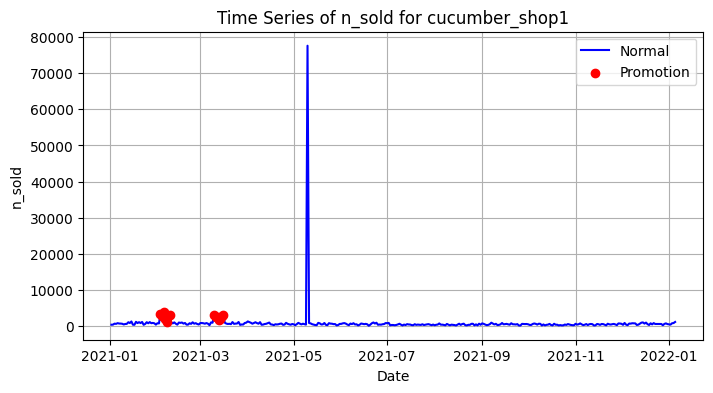

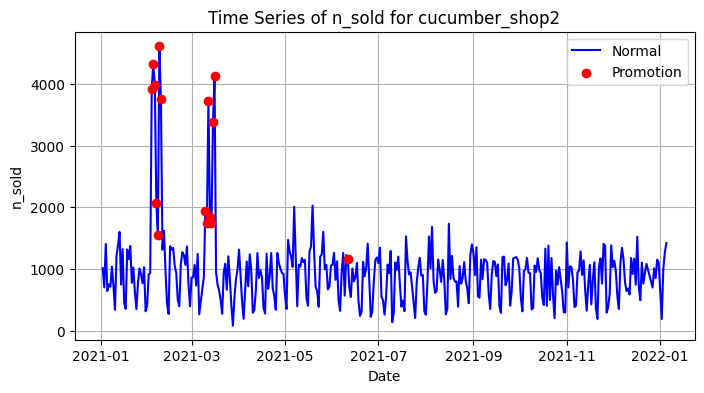

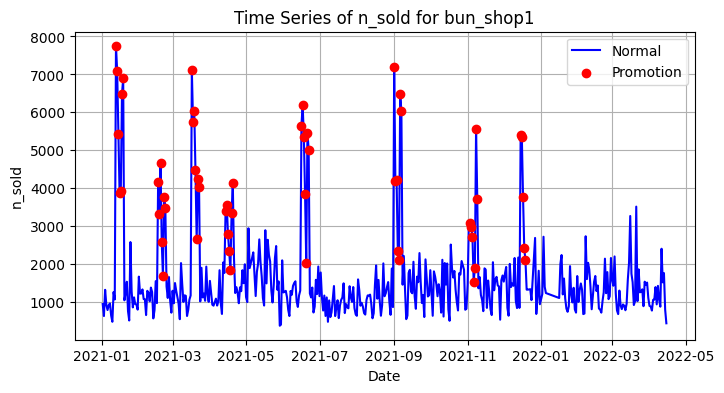

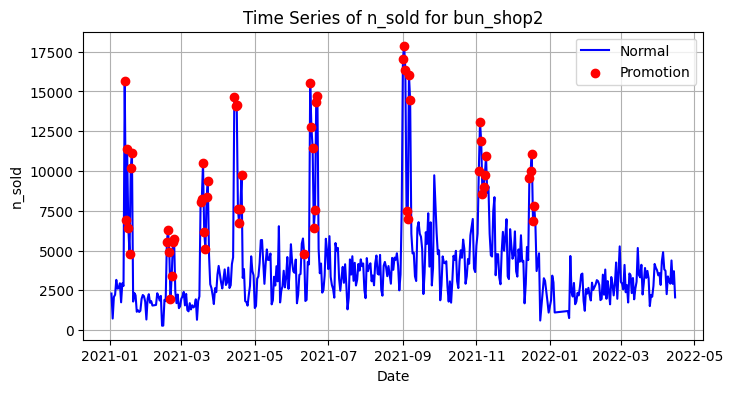

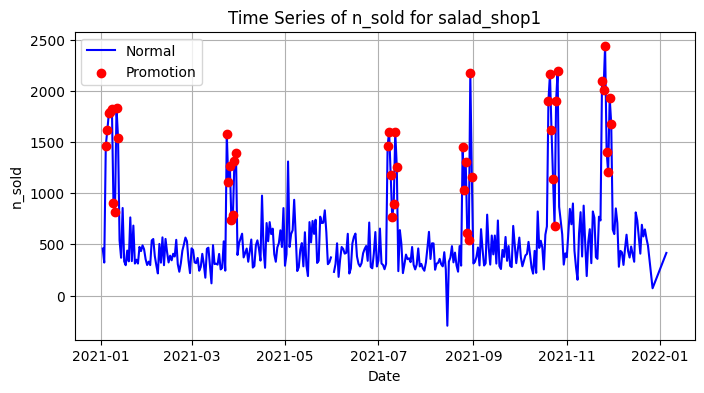

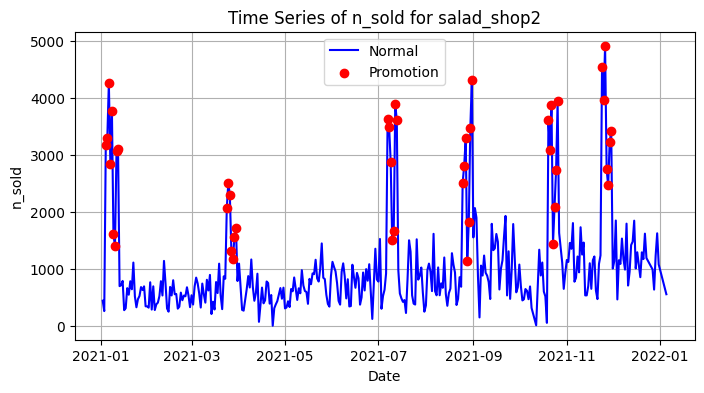

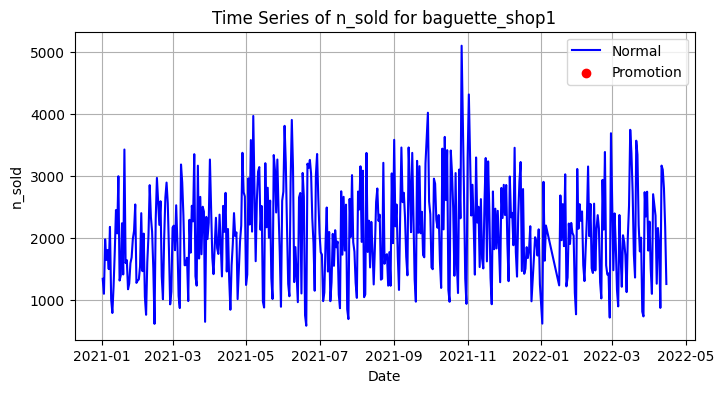

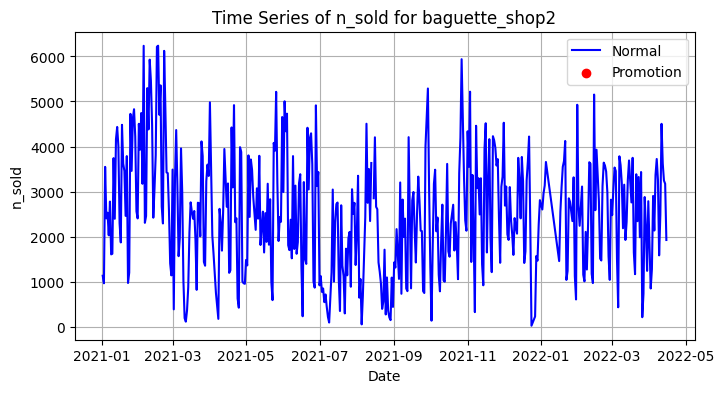

In [227]:
# Plot all time series sales
for item, df in item_shop_data.items():
    plot_time_series(df, 'n_sold', item)

We can see that n_sold doesn't have seasonal pattern and have a weak trend in some cases.

Note that promotion highly influences the number of sold items.

We also can see some outliers. For example, extremely high value for cucumber in shop 1, or value less than 0 for salad in shop 1. We will handle them in the next section.

Now let's move into price exploration.

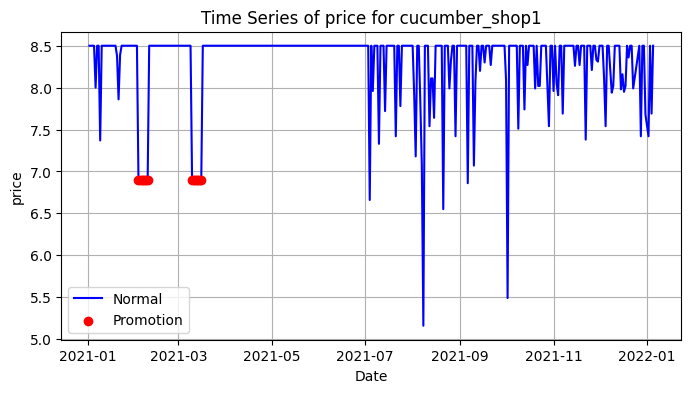

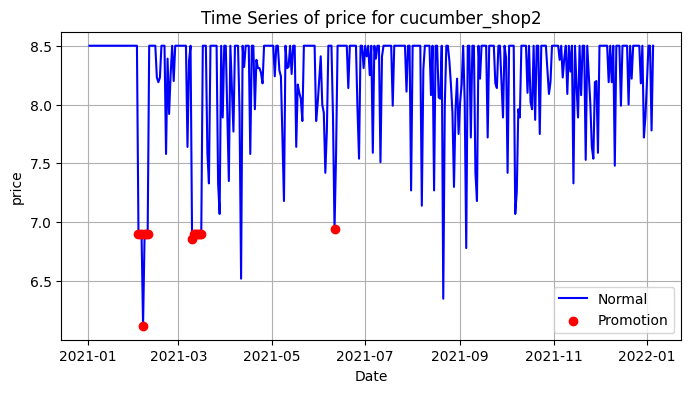

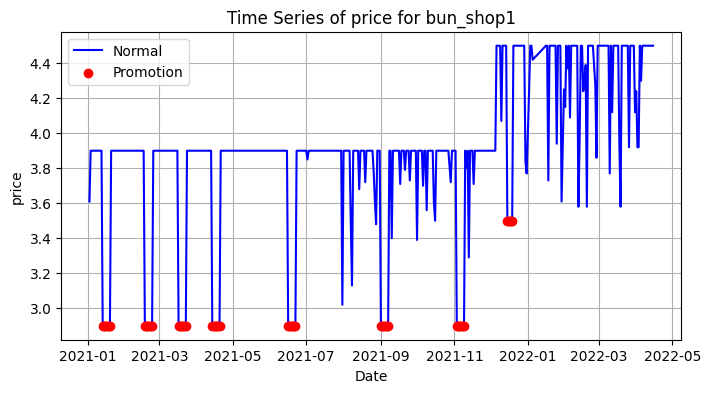

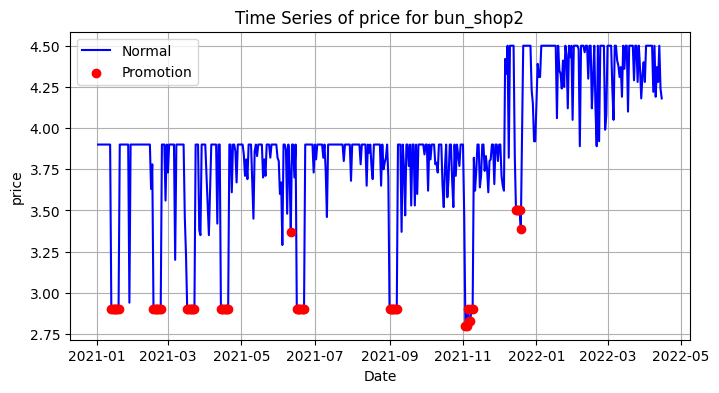

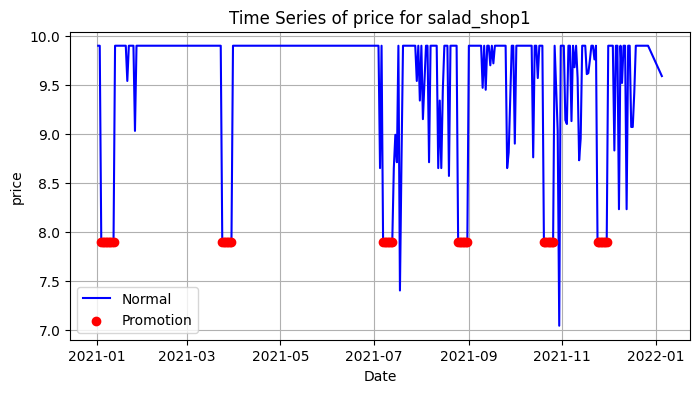

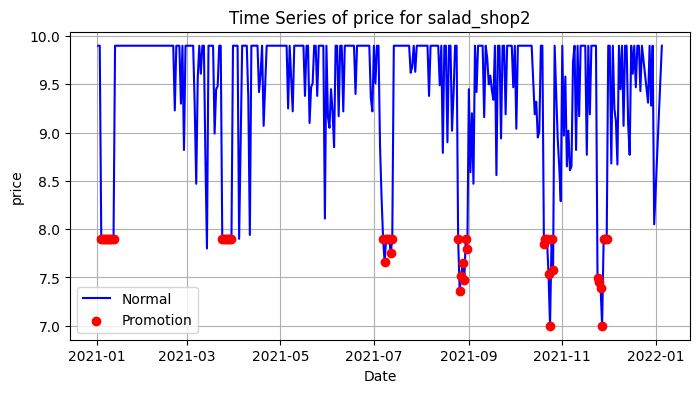

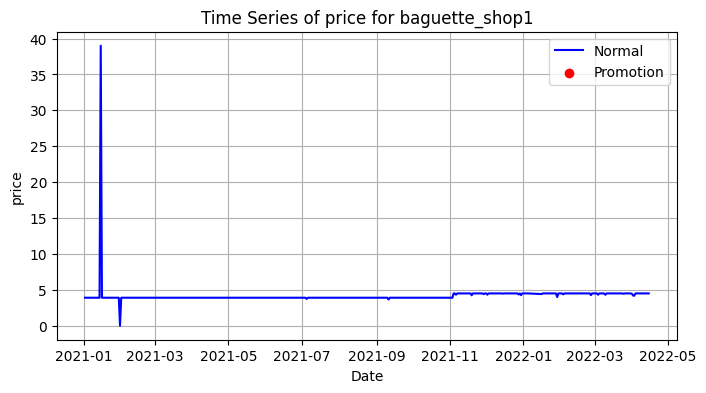

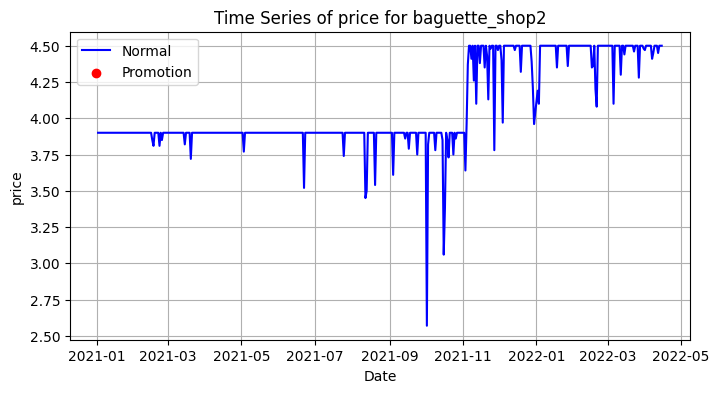

In [228]:
# Plot all time series prices
for item, df in item_shop_data.items():
    plot_time_series(df, 'price', item)

Note that sometimes price can be lower even when the item is not on the promotion.

Also note, that there are 2 outliers for the price of baguette in shop 1. There is almost a straight line, and 2 values are far away from this line, either too high or almost zero. It also needs to be handled. There is something wrong with shop 1 and its data:)

## Data Cleaning

### Missing Values Handling

Before handling outliers, let's check our data for missing values and remove if any are present.

In [229]:
# Check for missing values
for item, df in item_shop_data.items():
    print(f'Missing values in {item}: {df.isnull().any().any()}')

Missing values in cucumber_shop1: False
Missing values in cucumber_shop2: False
Missing values in bun_shop1: False
Missing values in bun_shop2: False
Missing values in salad_shop1: True
Missing values in salad_shop2: False
Missing values in baguette_shop1: False
Missing values in baguette_shop2: True


There are 2 dataframes with missing values. Let's explore them closer.

In [230]:
item_shop_data['salad_shop1'][item_shop_data['salad_shop1'].isnull().any(axis=1)]

shop_id       date item_name  n_sold  price  promotion    category
590        1 2021-06-01     salad     NaN    9.9      False  Vegetables

Okay, there is only one value missing. Let's check what is before and after this value.

In [231]:
idx = 590

index_loc = item_shop_data['salad_shop1'].index.get_loc(idx)

start_loc = max(index_loc - 2, 0)
end_loc = index_loc + 3

item_shop_data['salad_shop1'].iloc[start_loc:end_loc]

shop_id       date item_name  n_sold  price  promotion    category
582        1 2021-05-30     salad   325.0    9.9      False  Vegetables
586        1 2021-05-31     salad   372.0    9.9      False  Vegetables
590        1 2021-06-01     salad     NaN    9.9      False  Vegetables
594        1 2021-06-02     salad   231.0    9.9      False  Vegetables
598        1 2021-06-03     salad   309.0    9.9      False  Vegetables

In [232]:
item_shop_data['baguette_shop1'].query('date == "2021-06-01"')

shop_id       date item_name  n_sold  price  promotion category
591        1 2021-06-01  baguette  2746.0    3.9      False   Bakery

The shop wasn't closed at that day. So the missing value may be connected to the lack of the item in the store. We have the data for only 1 year. So instead of dropping it I will replace with the mean of 2 previous and 2 following values.

In [233]:
idxs = [582, 586, 594, 598]

sum = 0
for idx in idxs:
    sum += item_shop_data['salad_shop1'].loc[idx, 'n_sold']

average_n_sold = sum / len(idxs)
item_shop_data['salad_shop1'].loc[590, 'n_sold'] = average_n_sold

Now let's look at another dataframe with missing values.

In [234]:
item_shop_data['baguette_shop2'][item_shop_data['baguette_shop2'].isnull().any(axis=1)]

shop_id       date item_name  n_sold  price  promotion category
2500        2 2021-08-14  baguette     NaN    3.9      False   Bakery

There is only one missing value. Let's use the approach from the previous value.

In [235]:
idx = 2500

index_loc = item_shop_data['baguette_shop2'].index.get_loc(idx)

start_loc = max(index_loc - 2, 0)
end_loc = index_loc + 3

item_shop_data['baguette_shop2'].iloc[start_loc:end_loc]

shop_id       date item_name  n_sold  price  promotion category
2492        2 2021-08-12  baguette  2347.0   3.45      False   Bakery
2496        2 2021-08-13  baguette  3635.0   3.50      False   Bakery
2500        2 2021-08-14  baguette     NaN   3.90      False   Bakery
2504        2 2021-08-15  baguette  2853.0   3.90      False   Bakery
2508        2 2021-08-16  baguette  4205.0   3.90      False   Bakery

In [236]:
item_shop_data['bun_shop2'].query('date == "2021-08-14"')

shop_id       date item_name  n_sold  price  promotion category
2498        2 2021-08-14       bun  2529.0    3.9      False   Bakery

The case is similar to what we've seen before. Let's replace the value the same way we did before.

In [237]:
idxs = [2492, 2496, 2504, 2508]

sum = 0
for idx in idxs:
    sum += item_shop_data['baguette_shop2'].loc[idx, 'n_sold']

average_n_sold = sum / len(idxs)
item_shop_data['baguette_shop2'].loc[2500, 'n_sold'] = average_n_sold

### Outlier Handling

Before calculating total sales, we need to handle some of the outliers we have detected earlier.

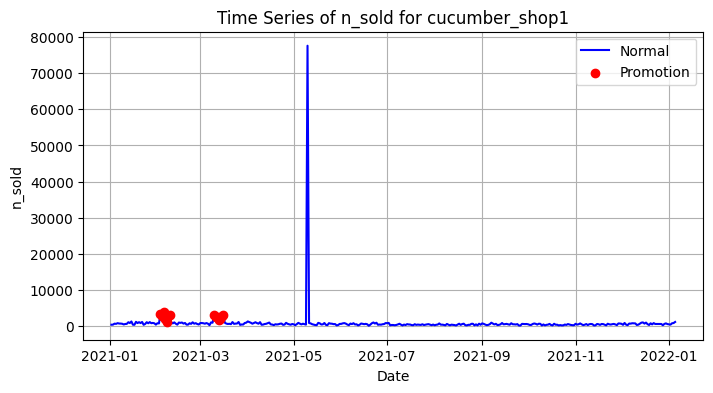

In [238]:
plot_time_series(item_shop_data['cucumber_shop1'], 'n_sold', 'cucumber_shop1')

There is no particular trend in the data. So let's replace sales for that day with the average value from all other dates, except those when the item was on promotion.

In [239]:
# Replace outlier
cucumber_shop1 = item_shop_data['cucumber_shop1']
cucumber_shop1_no_promo = cucumber_shop1[cucumber_shop1['promotion'] == False]
average_n_sold = cucumber_shop1_no_promo['n_sold'].mean()
row_to_replace = cucumber_shop1['n_sold'].idxmax()
cucumber_shop1.loc[row_to_replace, 'n_sold'] = average_n_sold

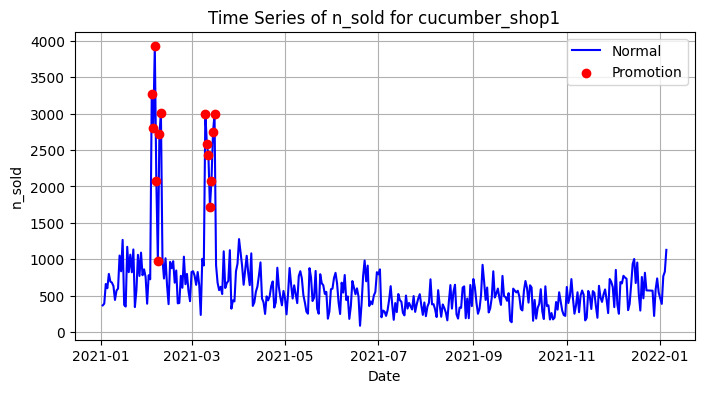

In [240]:
plot_time_series(cucumber_shop1, 'n_sold', 'cucumber_shop1')

Now data looks much better. Let's move to next values.

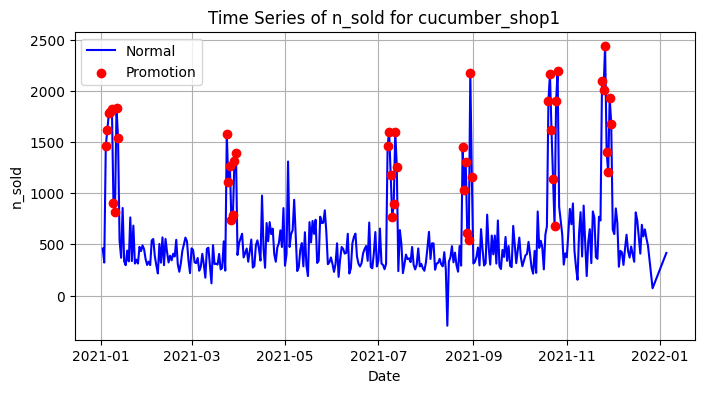

In [241]:
plot_time_series(item_shop_data['salad_shop1'], 'n_sold', 'cucumber_shop1')

In [242]:
item_shop_data['salad_shop1'].loc[item_shop_data['salad_shop1']['n_sold'].idxmin(), 'n_sold']

-295.0

Indeed, the number of sold items is less than 0. Let's replace the value with the average of 2 neighbouring values.

In [243]:
# Remove outlier
index = item_shop_data['salad_shop1']['n_sold'].idxmin()
average_neighbors = (item_shop_data['salad_shop1'].loc[index-4, 'n_sold'] + item_shop_data['salad_shop1'].loc[index+4, 'n_sold']) / 2
item_shop_data['salad_shop1'].loc[index, 'n_sold'] = average_neighbors

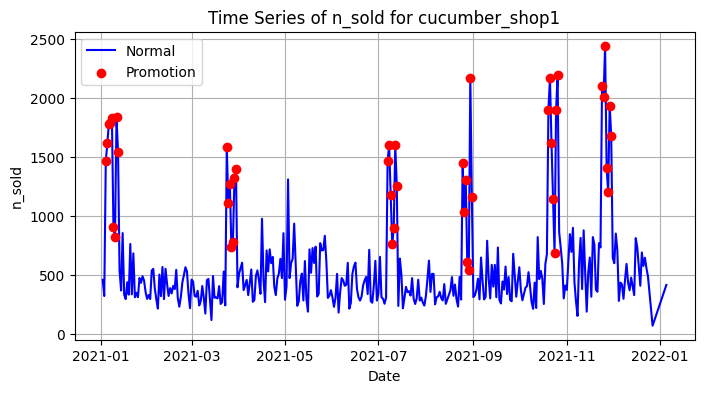

In [244]:
plot_time_series(item_shop_data['salad_shop1'], 'n_sold', 'cucumber_shop1')

Now we can see that one value in the end also look like an outlier. First, let's clean 'obvious' outliers, and then move to the ones like this.

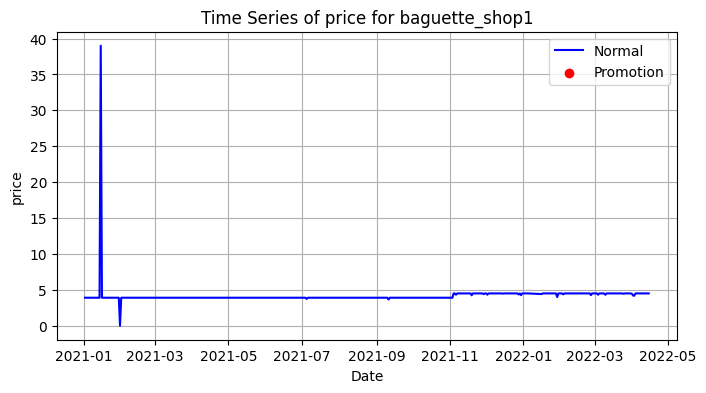

In [245]:
plot_time_series(item_shop_data['baguette_shop1'], 'price', 'baguette_shop1')

Let's replace incorrect values with the most common value during that period of time.

In [246]:
# Remove outlier
max_idx = item_shop_data['baguette_shop1']['price'].idxmax()
min_idx = item_shop_data['baguette_shop1']['price'].idxmin()
new_value = item_shop_data['baguette_shop1']['price'].mode()[0]
item_shop_data['baguette_shop1'].loc[max_idx, 'price'] = new_value
item_shop_data['baguette_shop1'].loc[min_idx, 'price'] = new_value

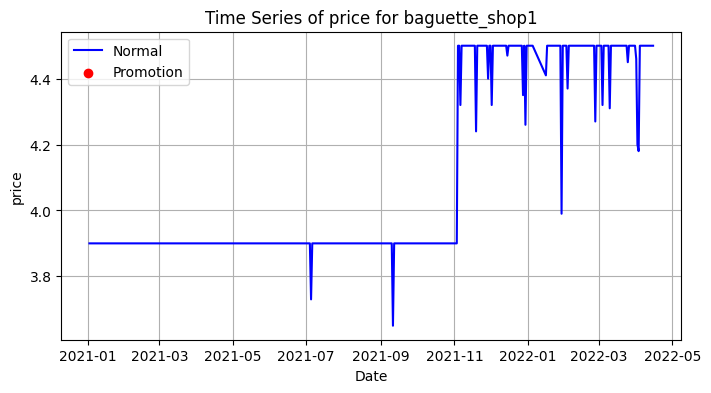

In [247]:
plot_time_series(item_shop_data['baguette_shop1'], 'price', 'baguette_shop1')

Now we can see the real difference in price.

Now, let's try to use boxplot to detect all other outliers.

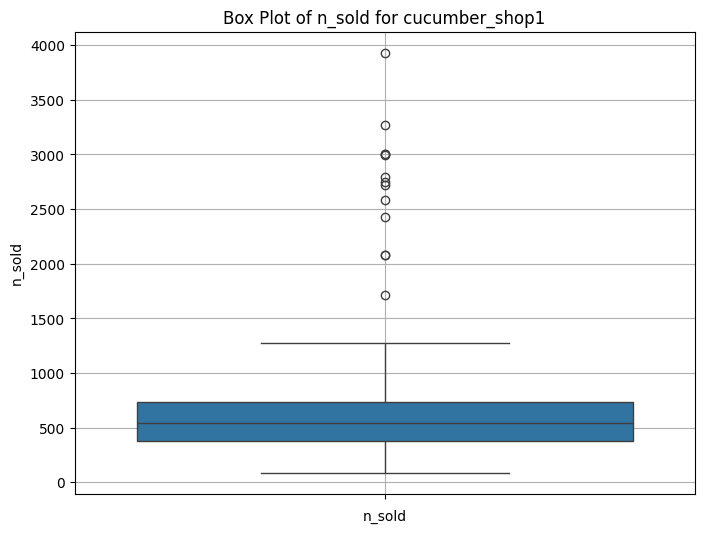

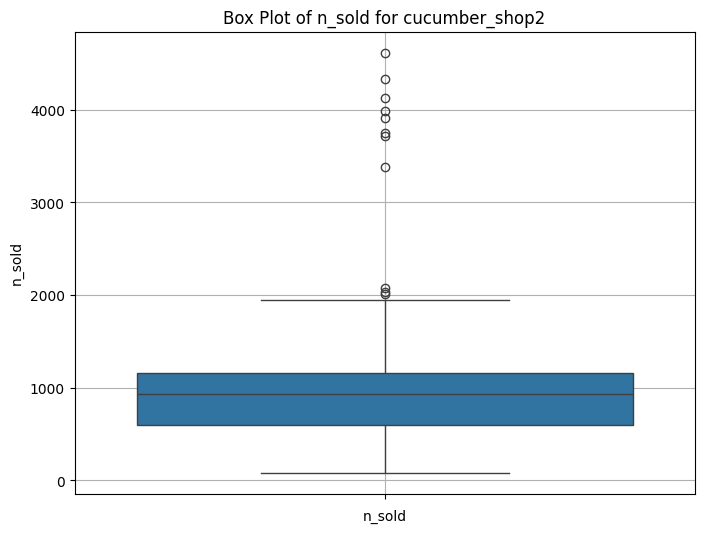

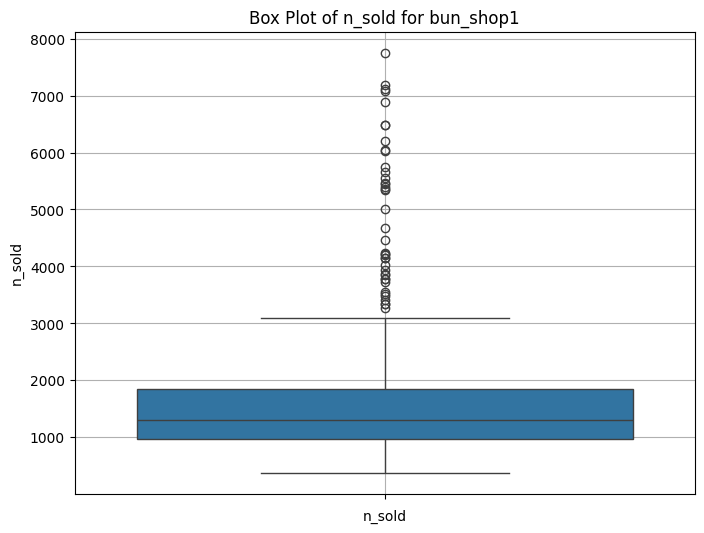

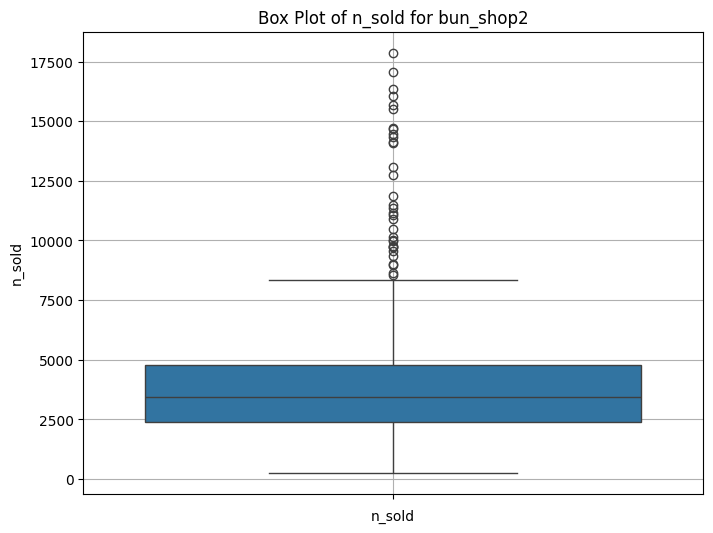

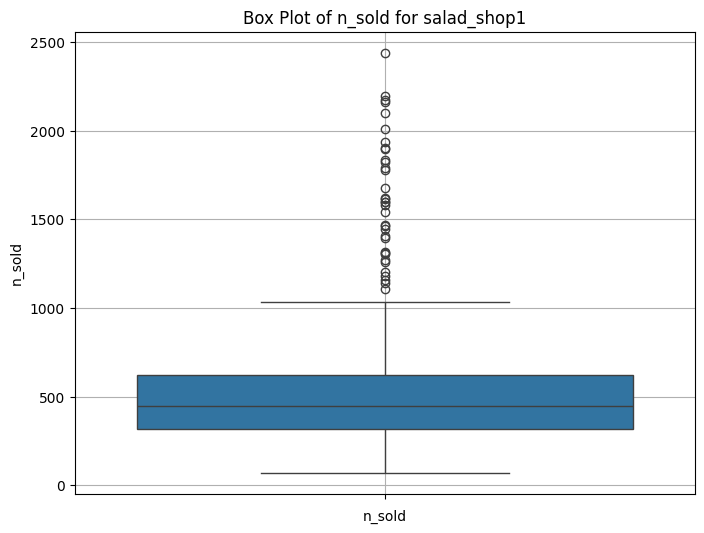

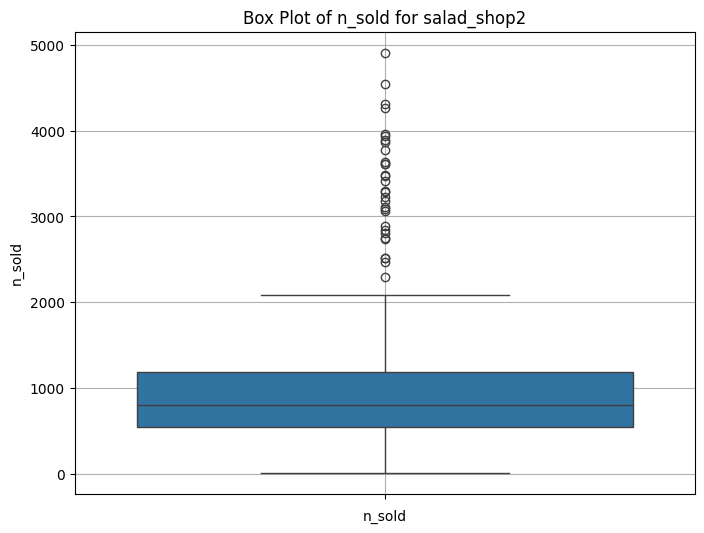

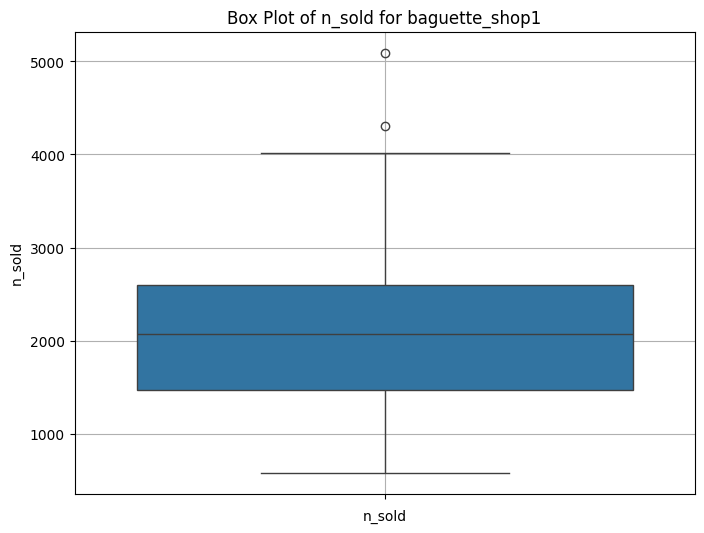

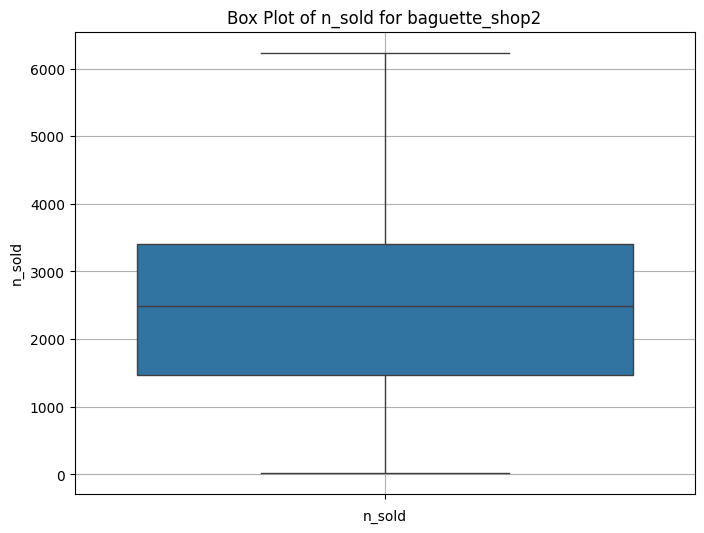

In [248]:
import seaborn as sns

for key, df in item_shop_data.items():
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df['n_sold'])
    plt.title(f'Box Plot of n_sold for {key}')
    plt.xlabel('n_sold')
    plt.grid(True)
    plt.show()

Note that almost each boxplot gives us a lot of values as outliers. This is likely because when item is on promotion, its sales are much higher.

So, we will detect and remove outliers manually.

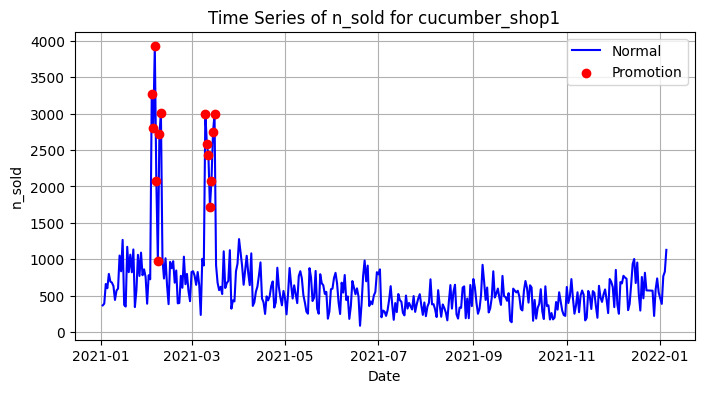

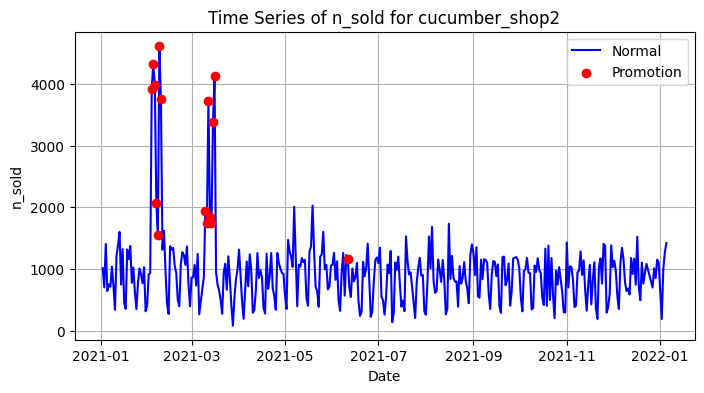

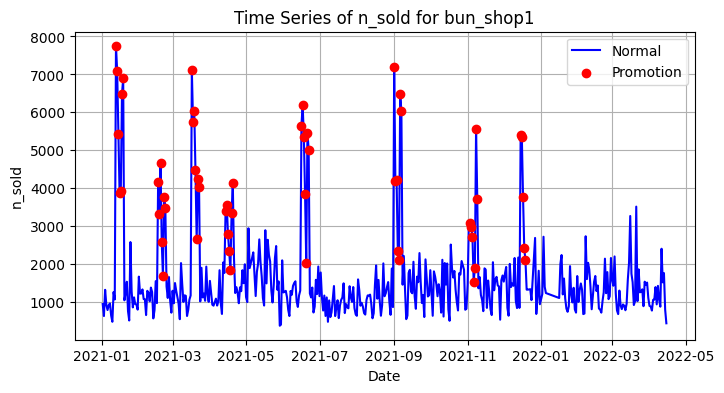

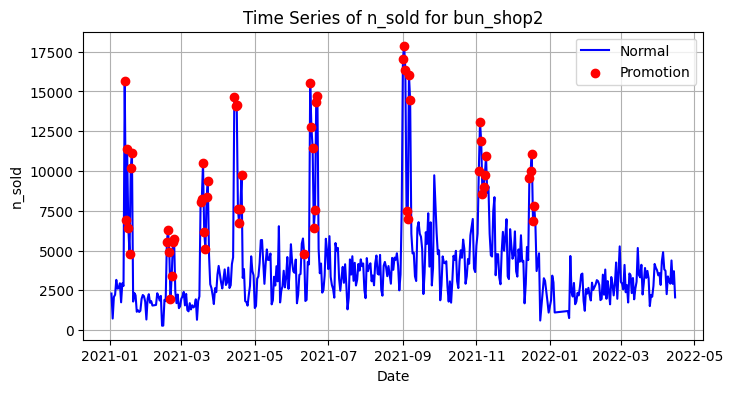

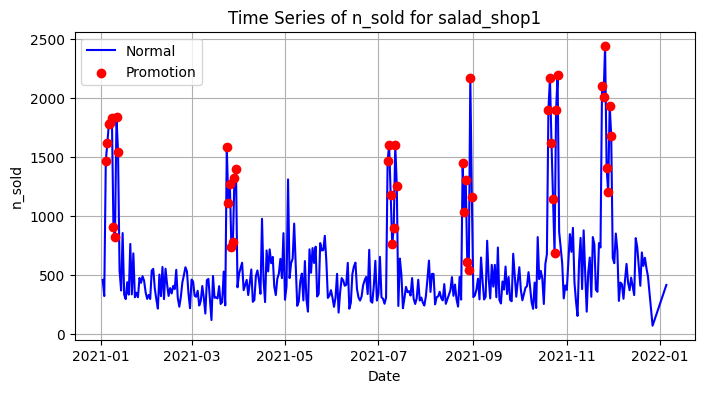

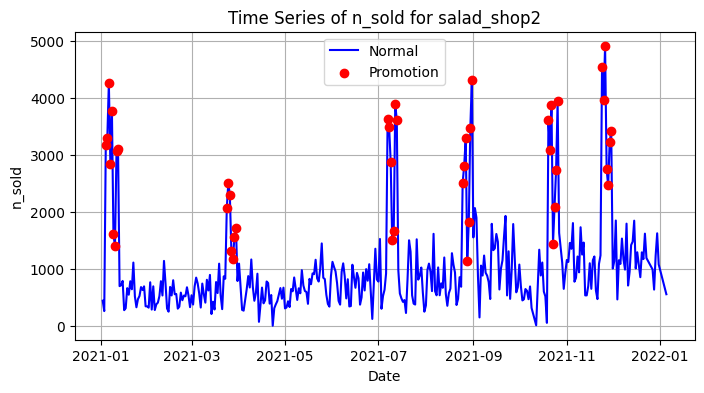

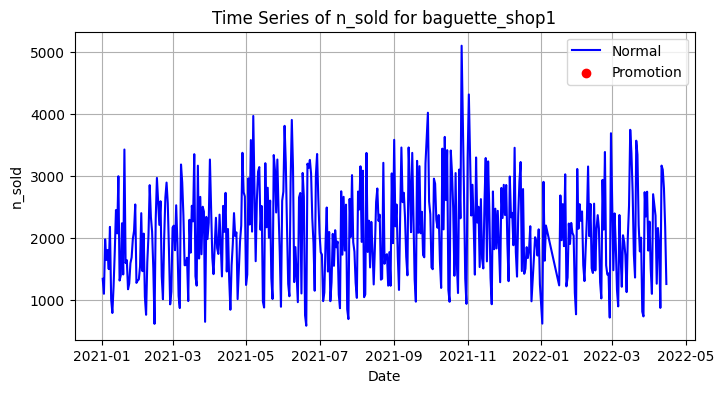

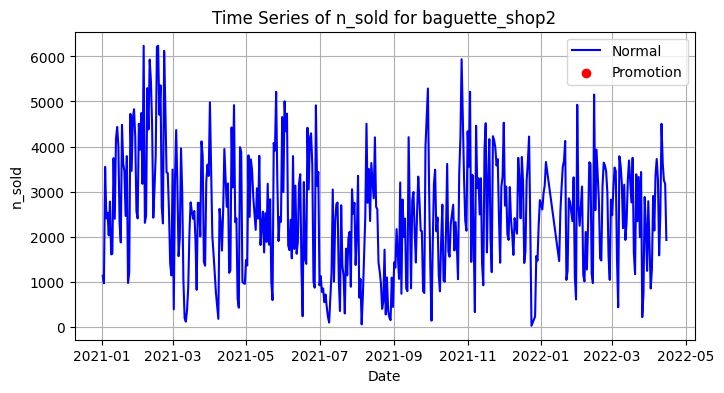

In [249]:
for item, df in item_shop_data.items():
    plot_time_series(df, 'n_sold', item)

There are 2 values that need to be handled. First is the minimum value for salad quantity in shop 1. Second is the maximum value for baguette quantity in shop 1.

Let's replace first by the average of 2 neighbouring and second by the 2nd largst value from the series.

In [250]:
item_shop_data['salad_shop1']['n_sold'].idxmin()

1409

In [251]:
item_shop_data['salad_shop1'].tail()

shop_id       date item_name  n_sold  price  promotion    category
1398        1 2021-12-22     salad   646.0   9.90      False  Vegetables
1402        1 2021-12-23     salad   558.0   9.90      False  Vegetables
1405        1 2021-12-24     salad   487.0   9.90      False  Vegetables
1409        1 2021-12-27     salad    71.0   9.90      False  Vegetables
1434        1 2022-01-05     salad   416.0   9.59      False  Vegetables

Note that there is a missing data around that point in time. A few of these days can be due to Christmas holidays. Anyway, let't replace this value with the average of previous and next values.

In [252]:
item_shop_data['salad_shop1'].loc[1409, 'n_sold'] = \
 (item_shop_data['salad_shop1'].loc[1405, 'n_sold'] + item_shop_data['salad_shop1'].loc[1434, 'n_sold']) / 2

In [253]:
item_shop_data['baguette_shop1']['n_sold'].nlargest(2)

1179    5093.0
1199    4309.0
Name: n_sold, dtype: float64

Now, we need to replace the first value by the second one.

In [254]:
# Replace value
item_shop_data['baguette_shop1'].loc[1179, 'n_sold'] = item_shop_data['baguette_shop1'].loc[1199, 'n_sold']

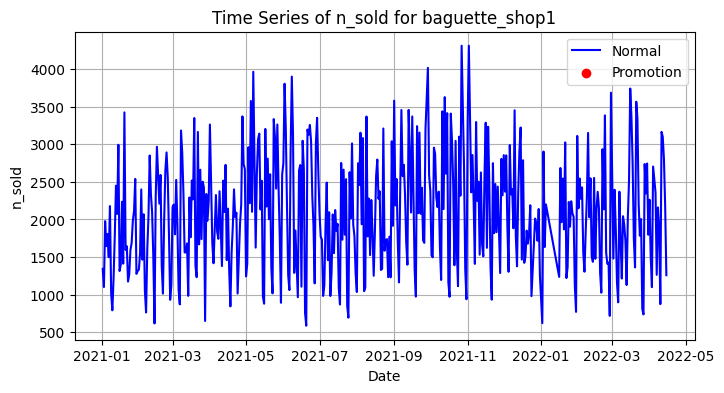

In [255]:
plot_time_series(item_shop_data['baguette_shop1'], 'n_sold', 'baguette_shop1')

Even though we didn't change much and these outliers were not that obvious, we did a good job. Because both time series look better.

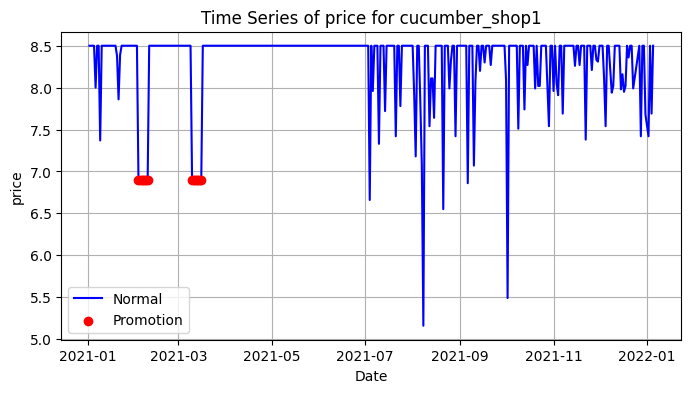

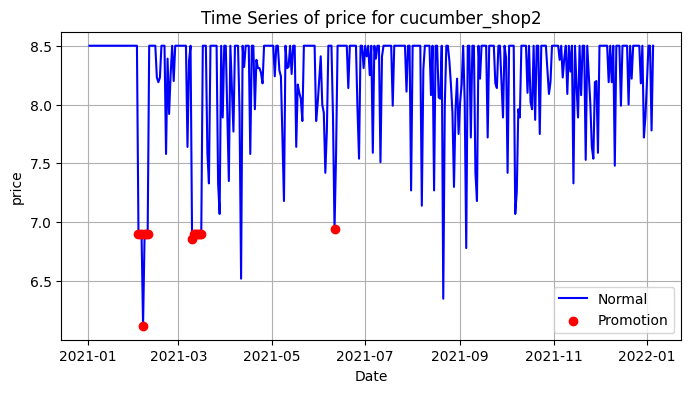

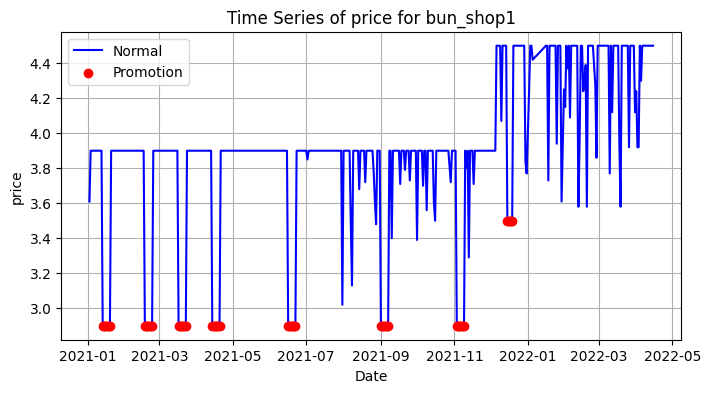

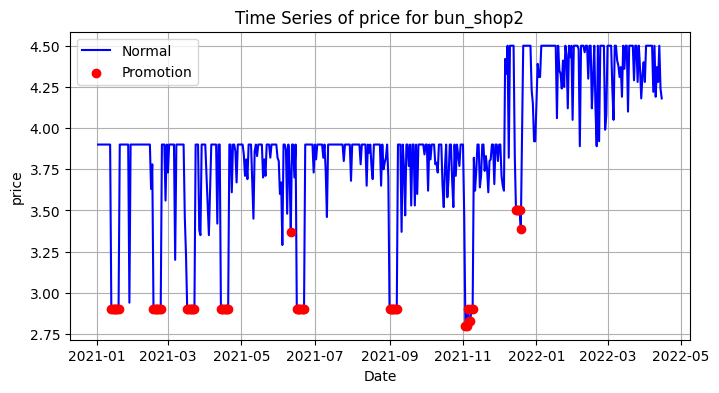

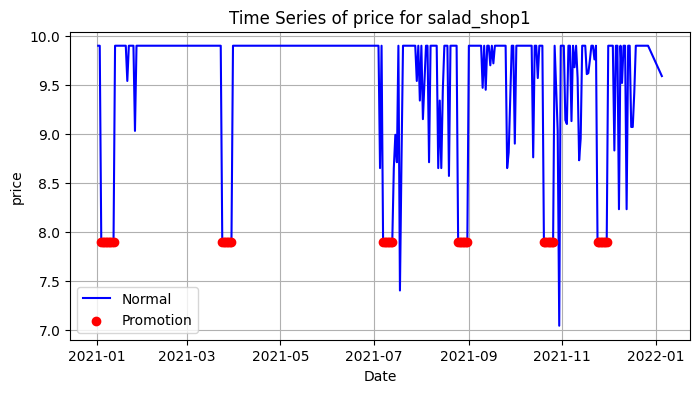

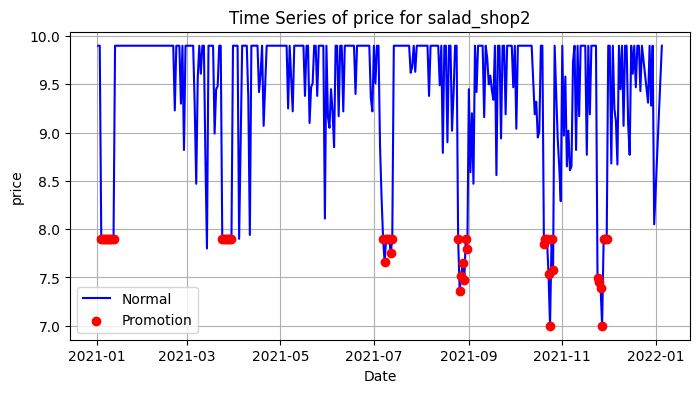

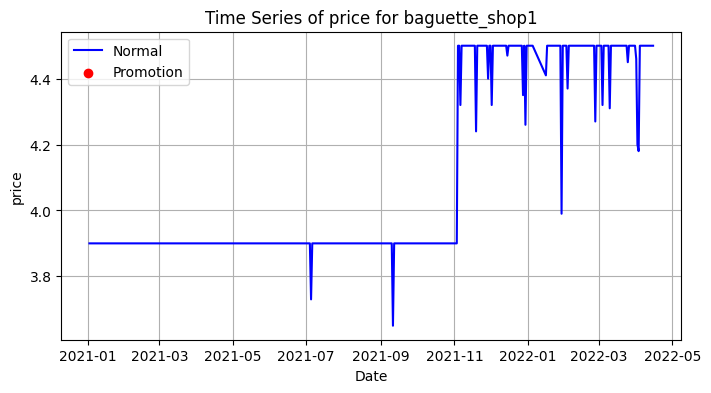

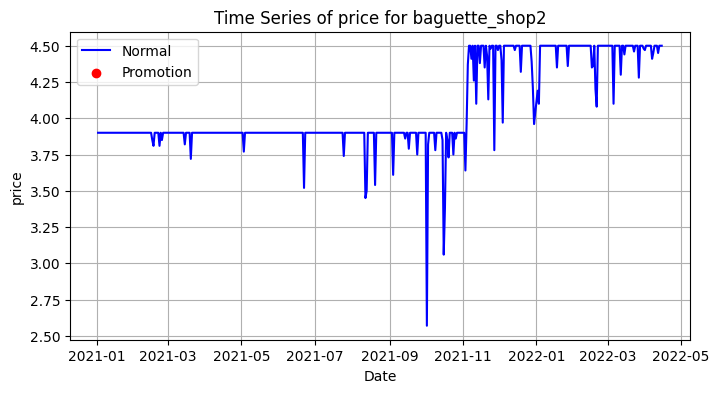

In [256]:
for item, df in item_shop_data.items():
    plot_time_series(df, 'price', item)

All prices look good. We don't know the reasons why the prices were getting lower if items are not on promotion. So, here we finish with outlier removal.

## Feature Analysis

### Feature Correlations

Let's now explore the correlation of the features. Here are the assumptions we can make about the data:
* The lower the price, the higher are sales
* Promotion status influences number of sold items

In [257]:
# Concat all data
data_cleaned = pd.concat(list(item_shop_data.values()))

In [258]:
# Check correlation
correlation = data_cleaned[['price', 'n_sold']].corr()
print(correlation)

           price    n_sold
price   1.000000 -0.551128
n_sold -0.551128  1.000000


We can see, that there is a correlation indeed. The lower the price, the lower the higher number of sold items. But it's neither high nor low, medium I should say.

Let's now compare the correlations in different dataframes.

In [259]:
# Check individual correlations
for item, df in item_shop_data.items():
    correlation = df[['price', 'n_sold']].corr().loc['n_sold', 'price']
    print(f'Correlation for {item}:')
    print(correlation)

Correlation for cucumber_shop1:
-0.42676400500488865
Correlation for cucumber_shop2:
-0.32505006960920946
Correlation for bun_shop1:
-0.5980086647835192
Correlation for bun_shop2:
-0.6226916897241983
Correlation for salad_shop1:
-0.7121955715815429
Correlation for salad_shop2:
-0.7220405695876341
Correlation for baguette_shop1:
-0.001396132854902689
Correlation for baguette_shop2:
0.0712541316162131


Note that for salad correlation is very high. It can be due to its high price comparing to other items. The lower price provides higher absolute savings compared to other items, that's why sales grow more with lower price.

Also note, that there is almost zero correlation for baguette. It is the only item in our dataset that doesn't have any promotions.

Let's now check closer how promotion status influences sales.

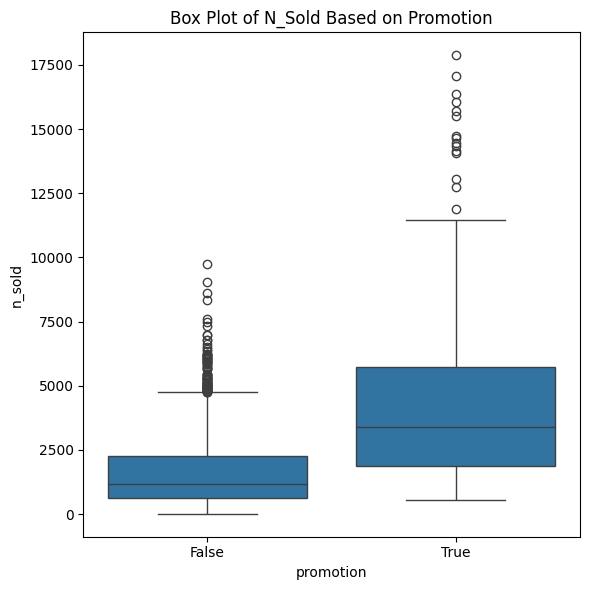

In [260]:
# Plot boxes of n_sold for different promotions
plt.figure(figsize=(6, 6))

sns.boxplot(data=data_cleaned, x='promotion', y='n_sold')
plt.title('Box Plot of N_Sold Based on Promotion')

plt.tight_layout()
plt.show()

It's might not be very insightful to compare all sales together, because they can be different from item to item. Let's explore them individually.

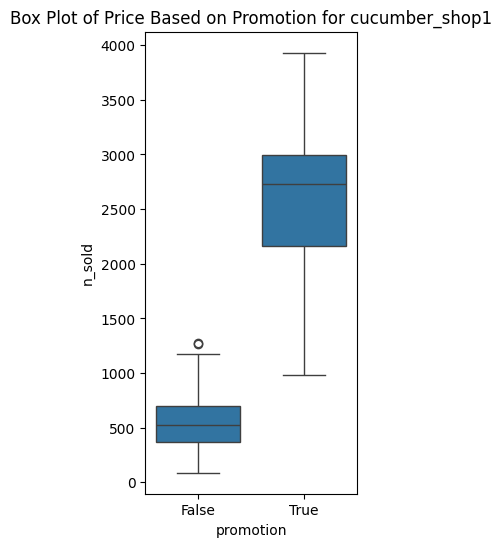

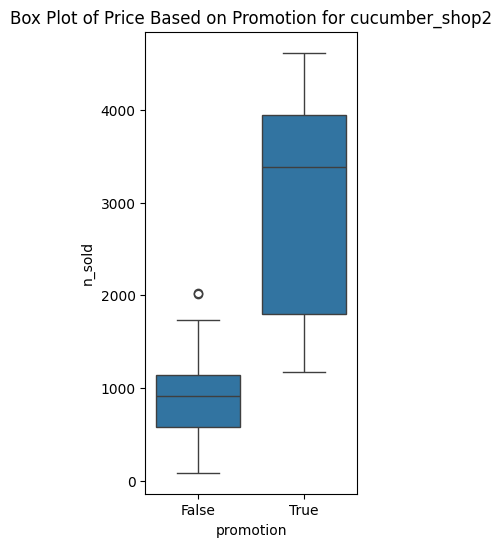

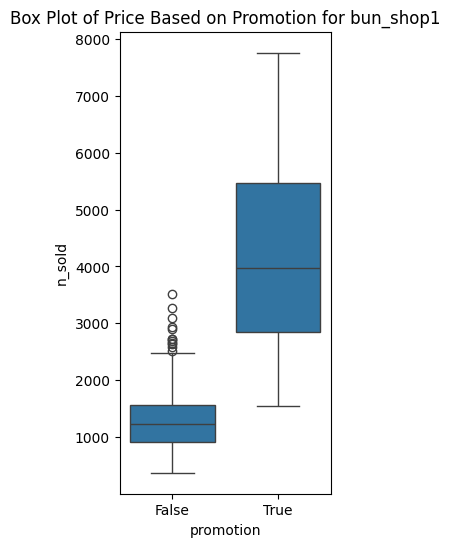

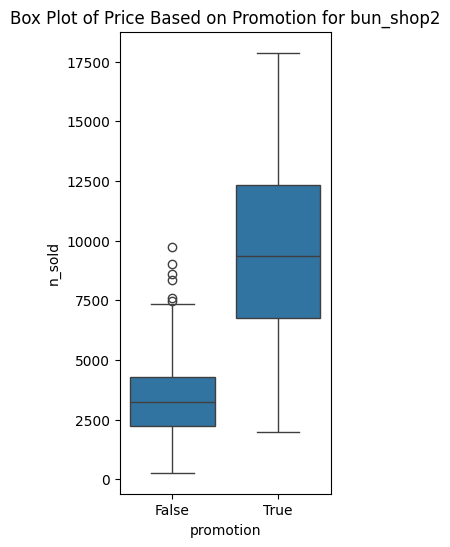

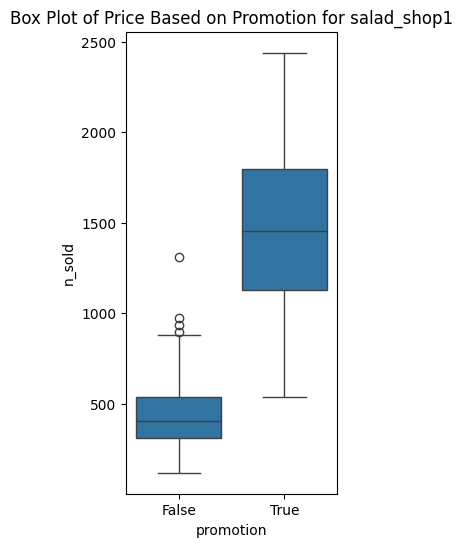

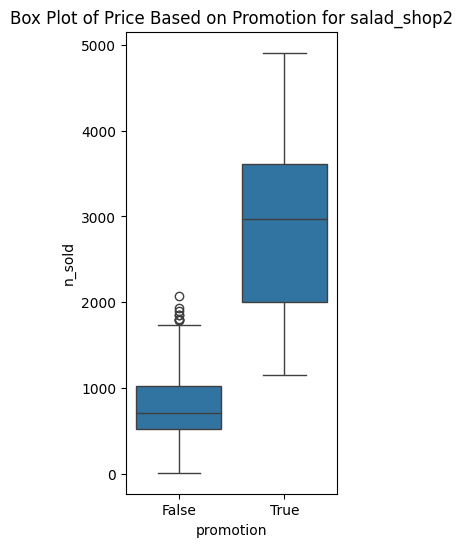

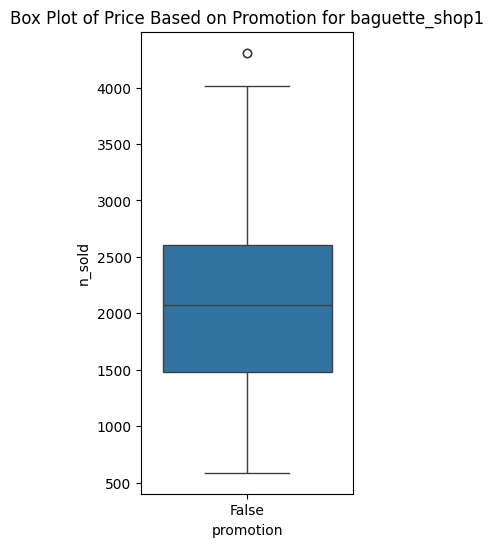

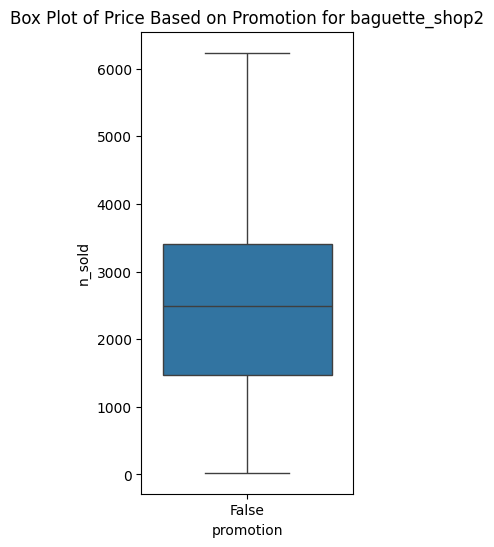

In [261]:
# Do the same individually
for item, df in item_shop_data.items():
    plt.figure(figsize=(6, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x='promotion', y='n_sold')
    plt.title(f'Box Plot of Price Based on Promotion for {item}')

There is a difference in sales for all the items. So, promotion has a significant influence on number of sold items.

Also not, that box plots for promotion = True show more spread in the data. The most likely reason for that is that promotions are different in size(price change).

### Intermediate Conclusion

Now we have a clean data, good understanding of what the data look like, and information about features. There isn't any precise requirement for this task. In my opinion, the next steps are very dependent on what features will be available for predictions in the future.

We have seen, that promotion and price have high influence on number of sold items. So, if we know the price for some time in the future, and whether it is a promotion or not, it can make our predictions much better. On the other hand, we should focus on other features like lag features, or for development of a distinct model for each item.

We also can make a decision for different periods of time. For now we have a daily data and, in my opinion, it makes sense to make daily predictions with this data. At least for Bakery items. For Vegetables the case may be different. They don't lose that much quality as Bakery and stay fresh for longer period, so we can make an aggregation for a few days.

Another question is that if we need to predict sales or number of sold items. Both are the same, if we know the future price. If not, then these are different cases.

In a perfect case we should ask stakeholders for what they need this prediction and what data they can provide to understand, what solution is the best. And here is how I would approach the problem on a real project.

But here, my stakeholder need to see my thoughs, so here they are:) And here is the solution I will showcase later. It is based on this line from the instructions: "Estimate a model which predicts next days sales".

So, I will predict the sales day by day. I also want to use promotion and price as something that we know in advance. I will also build a hierarchy, so that we predict sales not only by item, but also by shop and in total.

### Feature Engineering

Now, when we have defined our objective, we can calculate total sales and use them as a dependent variable.

In [ ]:
# Create price columns
for item, df in item_shop_data.items():
    df['sales'] = df['n_sold'] * df['price']

### Autocorrelation and Lag Features

Now, let's test the dependence of the variable with its past values. These dependencies can contain useful information that we don't see.

<Figure size 1000x600 with 0 Axes>

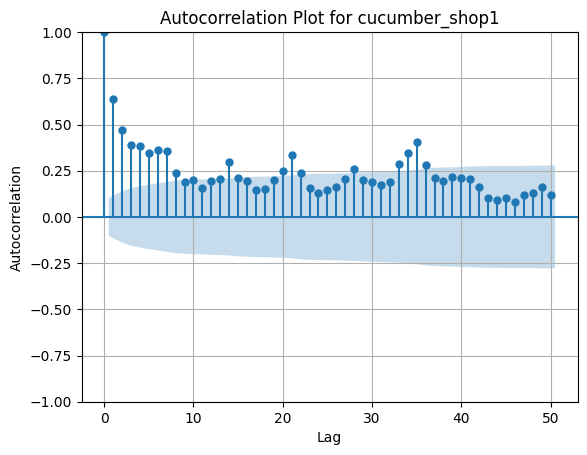

<Figure size 1000x600 with 0 Axes>

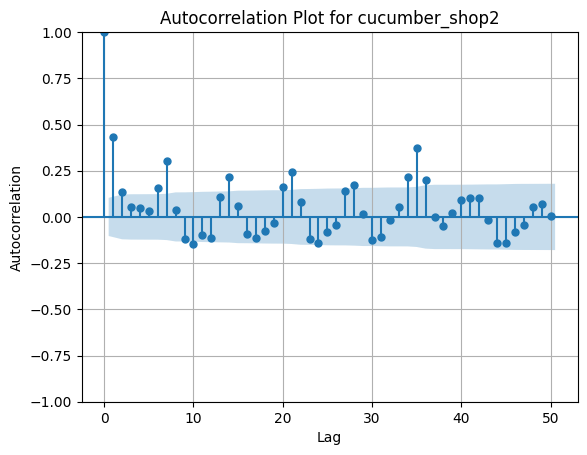

<Figure size 1000x600 with 0 Axes>

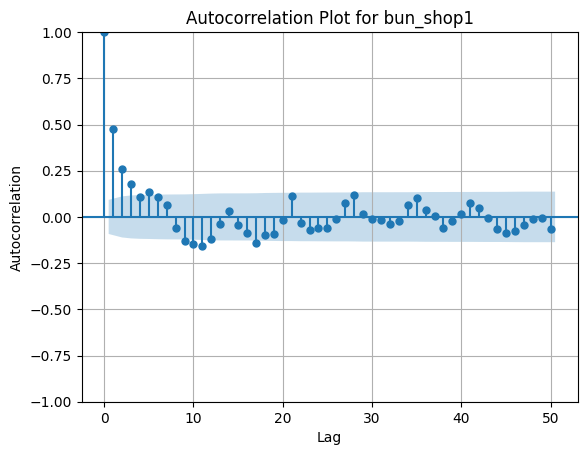

<Figure size 1000x600 with 0 Axes>

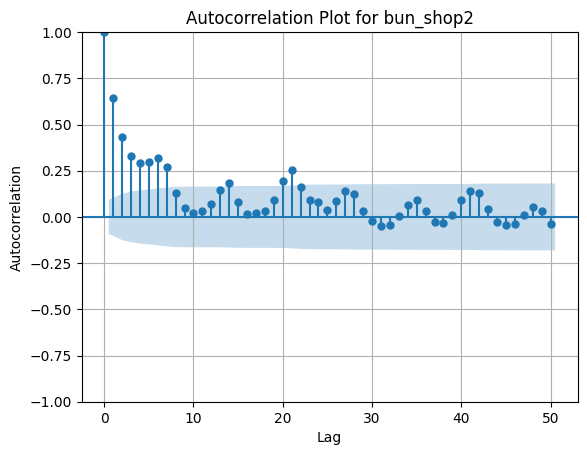

<Figure size 1000x600 with 0 Axes>

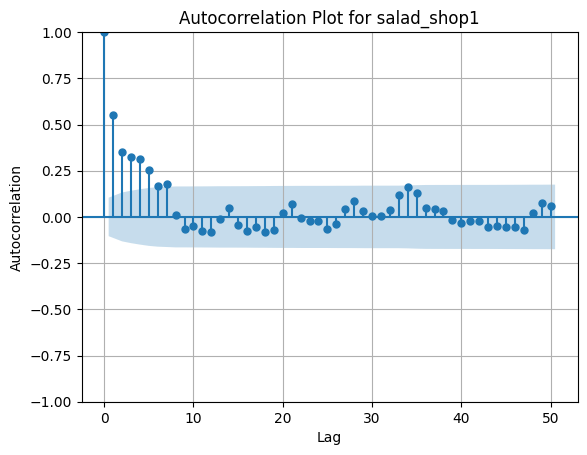

<Figure size 1000x600 with 0 Axes>

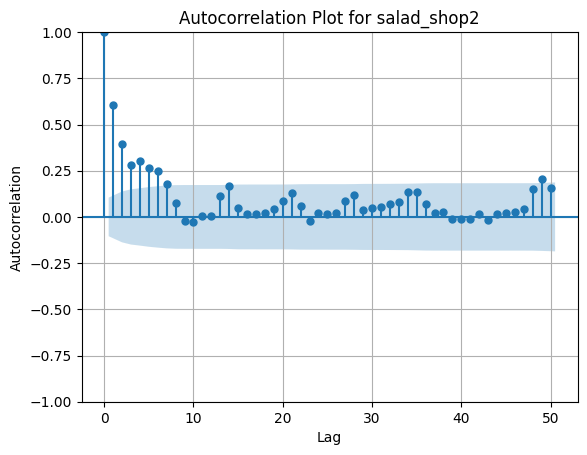

<Figure size 1000x600 with 0 Axes>

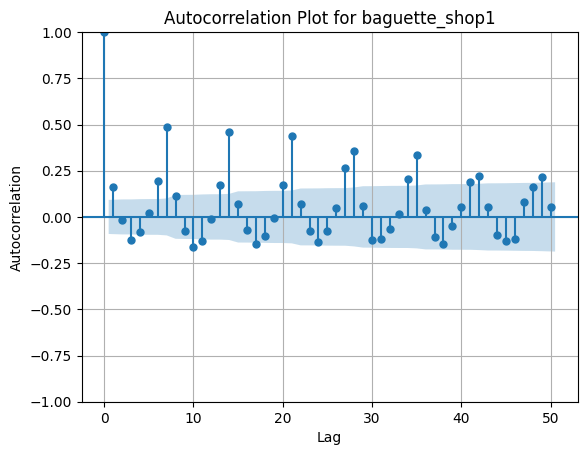

<Figure size 1000x600 with 0 Axes>

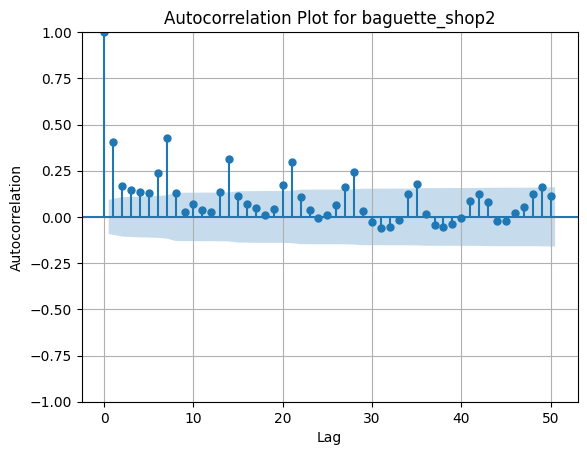

In [263]:
# Plot autocorrelation to define valuable lags
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

for item, df in item_shop_data.items():
    plt.figure(figsize=(10, 6))
    plot_acf(df['sales'], lags=50)
    plt.title(f'Autocorrelation Plot for {item}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.grid(True)
    plt.show()

Note that almost every sales have high correlation with the first previous value. So, in our case we can use autocorrelation. It can be a useful feature.

The second patterns we can note on the graph is a correlation between values 1, 2 and 3 weeks ago. It make sense, because grocery sales have repetitve patterns over the weekdays.

In conclusion, here are lag features we will add to our forecast:
* 1 day
* 7 days
* 14 days
* 21 days

In [ ]:
# Add lag features
for key, df in item_shop_data.items():
    df.set_index('date', inplace=True)

    df['lag_1'] = df['sales'].shift(1)
    df['lag_7'] = df['sales'].shift(7)
    df['lag_14'] = df['sales'].shift(14)
    df['lag_21'] = df['sales'].shift(21)

    df.reset_index(inplace=True)

    item_shop_data[key] = df

Now we successfully added lag features.

## Hierarchy Analysis

These are dimensions that we have in the data:
* Shop ID
* Category
* Item

So, there are multiple ways of how we can build the hierarchy. Once again, it would also depend on the requirements. Let's assume that we need to predict sales for each item in each shop, all sales for each shop, and all sales. It sounds like the most likely requirement. So, here is how our hierarchy will look like in this case:

![picture](https://drive.google.com/uc?export=view&id=1YNbWPryW7FEfbfdCYvItIlriL-1oRpCx)

In this case we will have to implement different models for different cases. Also note, that when we are aggregating data on Shop or Total level, we lose information about price and promotion of individual items. So, the best approach in this case is bottom-up.

However, if we have time to experiment with the task, we can explore more methods. Middle-out or top-down will likely be worse, because we lose some significant features. However, it might worth it to try reconciliation method and combine different approaches. But it requires much more work.

How we cleaned the data, added features and defined the task. It's time for modeling.

# Modeling

## Data Preparation

From my experience, Gradient Boosting algorithms are the best ML models for time series forecasting. They also can work with NaN values, which is an advantage in our case, because lag features are NaN in many cases. So let's stick to these models.

For the evaluation metric I will choose MAE. I think it's the best metric in this case.

Let's take the last look at our data.

In [265]:
item_shop_data['baguette_shop1'].head()

date  shop_id item_name  n_sold  price  promotion category   sales  \
0 2021-01-02        1  baguette  1343.0    3.9      False   Bakery  5237.7   
1 2021-01-03        1  baguette  1102.0    3.9      False   Bakery  4297.8   
2 2021-01-04        1  baguette  1978.0    3.9      False   Bakery  7714.2   
3 2021-01-05        1  baguette  1646.0    3.9      False   Bakery  6419.4   
4 2021-01-06        1  baguette  1806.0    3.9      False   Bakery  7043.4   

    lag_1  lag_7  lag_14  lag_21  
0     NaN    NaN     NaN     NaN  
1  5237.7    NaN     NaN     NaN  
2  4297.8    NaN     NaN     NaN  
3  7714.2    NaN     NaN     NaN  
4  6419.4    NaN     NaN     NaN

We don't need number of sold items, so let's drop it, and then we are done.

In [ ]:
# Drop n_sold to avoid data leakage
for key, df in item_shop_data.items():
    df.drop('n_sold', axis=1, inplace=True)

I will add year, month, day and day of week columns and use them instead of date columns.

In [ ]:
# Add date features
for key, df in item_shop_data.items():
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek

## Data Split

Data for Bakery category contains 1 year and 4 months of time series data. So, I will select year 2021 and January 2022 as a training set and other 3-3.5 months as a test set.

Situation with Vegetables is different. There is a data for 12 months only. So, I will select first 9.5 months as training set and other 2.5 as testing set.

In [269]:
def check_category(key):
    """
    This function returns the category of the item.
    """
    if key.split('_')[0] in ['baguette', 'bun']:
        return 'Bakery'
    elif key.split('_')[0] in ['salad', 'cucumber']:
        return 'Vegetables'
    else:
        return 'No such category'

In [270]:
train_dfs = {}
test_dfs = {}
bakery_split_date = '2022-02-01'
vegetables_split_date = '2021-09-15'

In [271]:
# Divide dataframes into train and test parts

for key, df in item_shop_data.items():
    if check_category(key) == 'Bakery':
        train_dfs[key] = df[df['date'] < bakery_split_date].drop(['item_name', 'category'], axis=1)
        test_dfs[key] = df[df['date'] >= bakery_split_date].drop(['item_name', 'category'], axis=1)
    elif check_category(key) == 'Vegetables':
        train_dfs[key] = df[df['date'] < vegetables_split_date].drop(['item_name', 'category'], axis=1)
        test_dfs[key] = df[df['date'] >= vegetables_split_date].drop(['item_name', 'category'], axis=1)

## Helper Function

In [273]:
def expanding_window_cv(df, target_column, model, initial_months=2, increment_months=2):
    """
    This function helps to implement cross validation with expanding window on time series data.
    """
    results = []

    # Get the minimum and maximum date
    min_date = df['date'].min()
    max_date = df['date'].max()

    current_train_end = min_date + pd.DateOffset(months=initial_months)

    i = 0
    while current_train_end < max_date:
        # Split the data
        train_data = df[df['date'] < current_train_end]
        test_data = df[df['date'] >= current_train_end]

        X_train = train_data.drop(columns=[target_column, 'date', 'shop_id'])
        y_train = train_data[target_column]
        X_test = test_data.drop(columns=[target_column, 'date', 'shop_id'])
        y_test = test_data[target_column]

        # Train the model
        model.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test)
        score = mean_absolute_error(y_test, y_pred)
        results.append(score)

        # Print or store results

        # Update the end of the training set
        current_train_end += pd.DateOffset(months=increment_months)

    return results

Now, when we have split the data and all the helper functions, we are ready to go to use models on it.

## Model Training

### XGBoost

Let's start with XGBoost. I use it the most both because of its efficiency and name.

In [274]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

xgb_reg = XGBRegressor(random_state=42)

xgb_results = []
for key, df in train_dfs.items():
    results = expanding_window_cv(df, 'sales', xgb_reg)
    xgb_results.append(results)
    print(f'Results for {key}: {np.mean(results)}')

Results for cucumber_shop1: 2260.695600216663
Results for cucumber_shop2: 2235.9648896526855
Results for bun_shop1: 1814.495968354621
Results for bun_shop2: 5388.832101001999
Results for salad_shop1: 1663.220606231874
Results for salad_shop2: 3446.2403242803157
Results for baguette_shop1: 2038.6658026755294
Results for baguette_shop2: 4071.602559651259


We got our first predictions. Let's check other models.

### LightGBM

In [275]:
import lightgbm as lgb

lgb_reg = lgb.LGBMRegressor(random_state=42, verbose=-1)

lgb_results = []
for key, df in train_dfs.items():
    results = expanding_window_cv(df, 'sales', lgb_reg)
    lgb_results.append(results)
    print(f'Results for {key}: {np.mean(results)}')

Results for cucumber_shop1: 2035.3903725507307
Results for cucumber_shop2: 2725.021711312372
Results for bun_shop1: 1992.5054806797225
Results for bun_shop2: 4779.717301527853
Results for salad_shop1: 1707.9436928272482
Results for salad_shop2: 3559.533336343448
Results for baguette_shop1: 1960.4272328159623
Results for baguette_shop2: 3778.8470237934


### CatBoost

In [ ]:
!pip install catboost

In [276]:
from catboost import CatBoostRegressor

catboost_reg = CatBoostRegressor(random_state=42, verbose=0)

catboost_results = []
for key, df in train_dfs.items():
    results = expanding_window_cv(df, 'sales', catboost_reg)
    catboost_results.append(results)
    print(f'Results for {key}: {np.mean(results)}')

Results for cucumber_shop1: 1882.7637119908939
Results for cucumber_shop2: 1748.4305369716158
Results for bun_shop1: 1592.5566451621687
Results for bun_shop2: 4879.769696004351
Results for salad_shop1: 1440.4646172002656
Results for salad_shop2: 3361.4014909557195
Results for baguette_shop1: 1925.9365861647175
Results for baguette_shop2: 3671.1498847402495


## Model Comparison

We now have tensors(well, lists of lists) where all the predictions with expanding windows are stored. Let's visualize them and see, which model for which node we should pick.

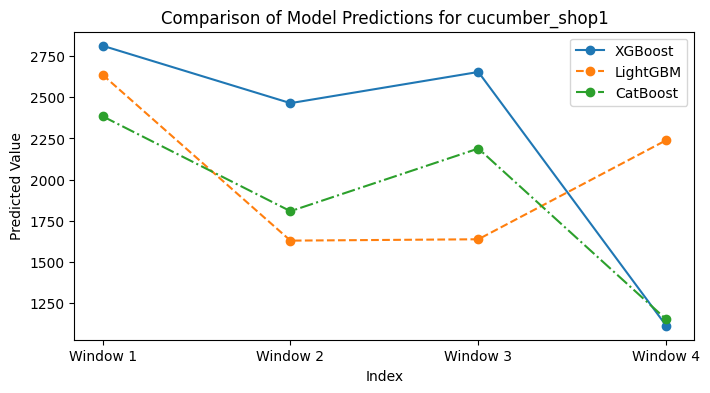

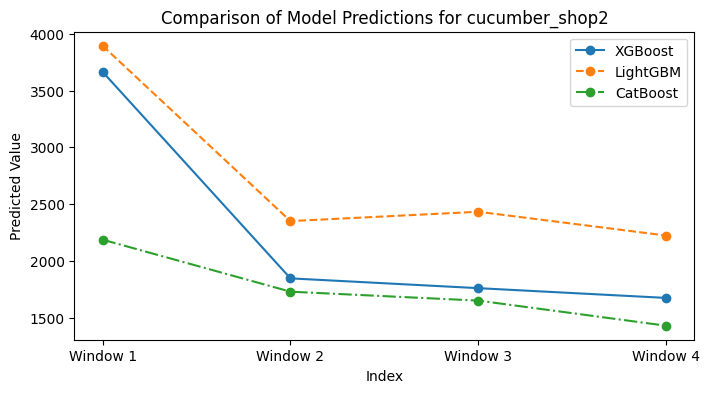

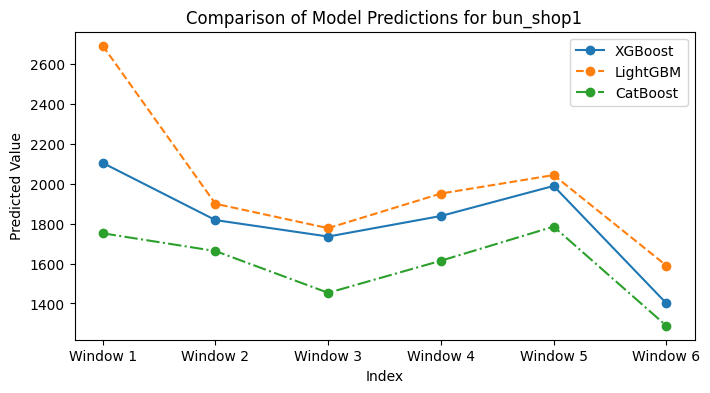

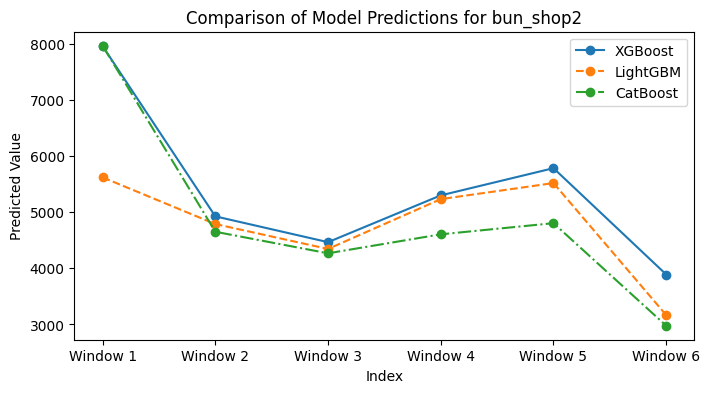

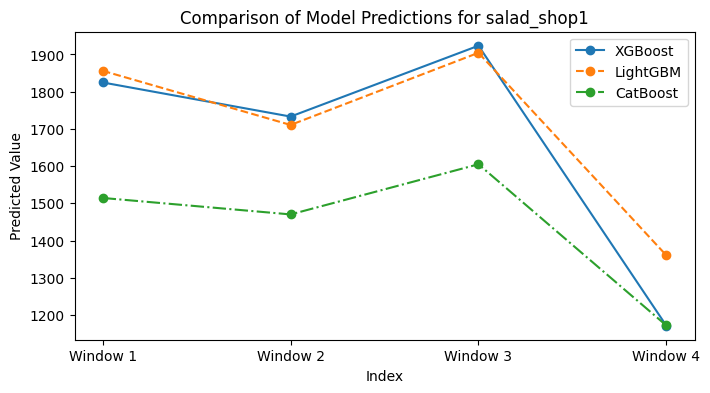

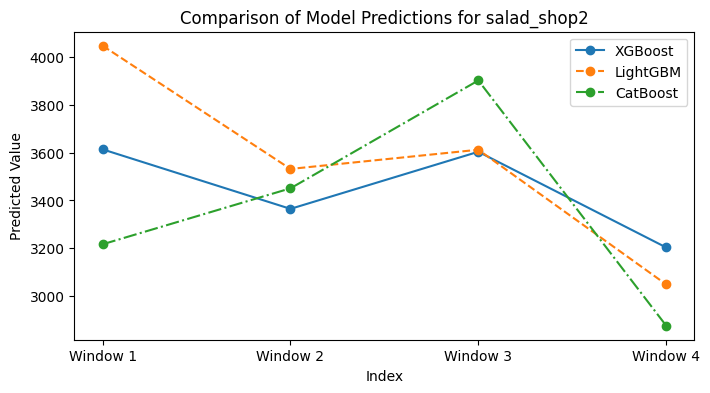

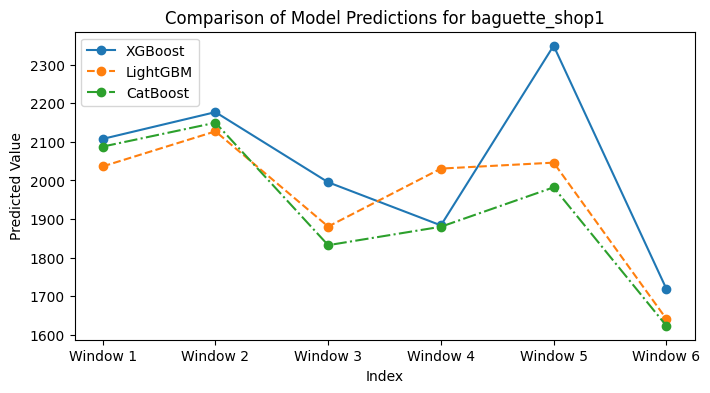

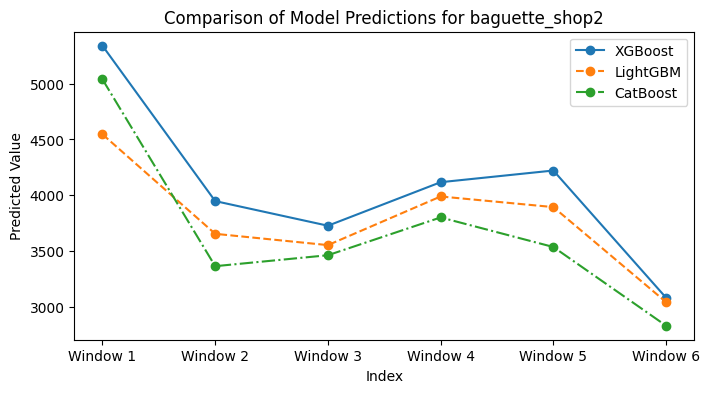

In [277]:
j = 0
for key, df in train_dfs.items():
    plt.figure(figsize=(8, 4))

    plt.plot(xgb_results[j], marker='o', label='XGBoost', linestyle='-')
    plt.plot(lgb_results[j], marker='o', label='LightGBM', linestyle='--')
    plt.plot(catboost_results[j], marker='o', label='CatBoost', linestyle='-.')

    plt.xlabel('Index')
    plt.ylabel('Predicted Value')
    plt.title(f'Comparison of Model Predictions for {key}')
    plt.xticks(range(len(xgb_results[j])), [f'Window {j + 1}' for j in range(len(xgb_results[j]))])
    plt.legend()

    plt.show()
    j += 1

We can see that CatBoost performs better than other models in many cases. But there are dataframes for which 2 or 3 models have comparable performance. Here is the breakdown:
* Cucumber shop 1: CatBoost and XGBoost have the same trend. We will test both
* Cucumber shop 2: CatBoost win
* Bun shop 1: CatBoost win
* Bun shop 2: all models have similar performance. We will test all 3
* Salad shop 1: CatBoost and XGBoost have the same trend. We will test both
* Salad shop 2: CatBoost win
* Baguette shop 1: CatBoost and LightGBM have the same trend. We will test both
* Baguette shop 2: all models have similar performance. We will test all 3

## Hyperparameter Tuning

### Cucumber Shop 1

In [278]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

catboost_param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

tscv = TimeSeriesSplit(n_splits=5)

catboost = CatBoostRegressor(early_stopping_rounds=50, verbose=0)

# Set up Randomized Search
random_search_catboost = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=catboost_param_grid,
    n_iter=10,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42
)

random_search_catboost.fit(train_dfs['cucumber_shop1'].drop(['sales', 'date', 'shop_id'], axis=1), train_dfs['cucumber_shop1']['sales'])

# Get the best estimator
best_catboost = random_search_catboost.best_estimator_

In [279]:
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

tscv = TimeSeriesSplit(n_splits=5)

xgb = XGBRegressor(objective='reg:absoluteerror', eval_metric='mae')

# Set up Randomized Search
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=10,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42
)

random_search_xgb.fit(train_dfs['cucumber_shop1'].drop(['sales', 'date', 'shop_id'], axis=1), train_dfs['cucumber_shop1']['sales'])

# Get the best estimator
best_xgb = random_search_xgb.best_estimator_

In [280]:
X_test = test_dfs['cucumber_shop1'].drop(['sales', 'date', 'shop_id'], axis=1)
y_test = test_dfs['cucumber_shop1']['sales']

# Make predictions with CatBoost
y_pred_catboost = best_catboost.predict(X_test)
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
print(f'CatBoost MAE: {mae_catboost}')

# Make predictions with XGBoost
y_pred_xgb = best_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f'XGBoost MAE: {mae_xgb}')

# Compare the models
if mae_catboost < mae_xgb:
    print('CatBoost is the better model based on MAE.')
else:
    print('XGBoost is the better model based on MAE.')

CatBoost MAE: 1032.760214208551
XGBoost MAE: 1107.9477256133177
CatBoost is the better model based on MAE.


Note that error is much lower than it was before fine tuning. Let's visualize the results.

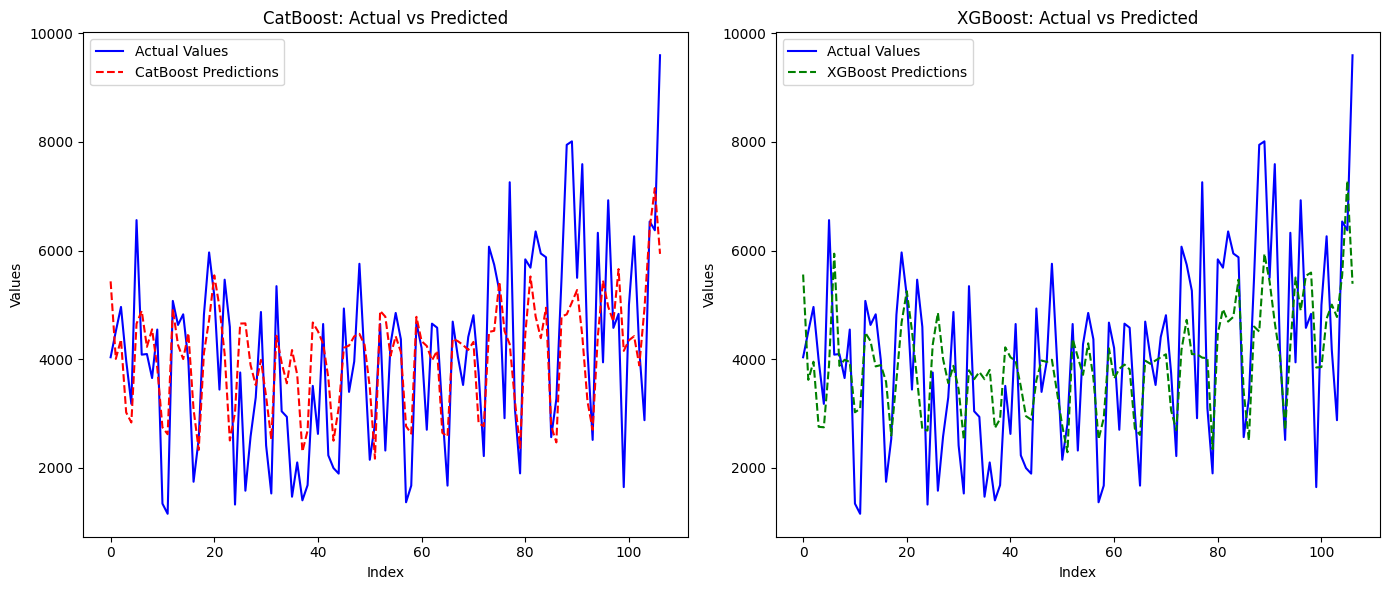

In [281]:
plt.figure(figsize=(14, 6))

# Plot for CatBoost
plt.subplot(1, 2, 1)
plt.plot(y_test.values, label='Actual Values', color='blue')
plt.plot(y_pred_catboost, label='CatBoost Predictions', color='red', linestyle='--')
plt.title('CatBoost: Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Plot for XGBoost
plt.subplot(1, 2, 2)
plt.plot(y_test.values, label='Actual Values', color='blue')
plt.plot(y_pred_xgb, label='XGBoost Predictions', color='green', linestyle='--')
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

Note that prediction of models are very similar. And both of them have a similar pattern of modeling predictions closer to mean value of the data. Both of them are good is catching the patterns of the data.

### Bun Shop 2

Let's select the best model for Bun in shop 2. Here we have all 3 models as potential candidates.

In [282]:
catboost_param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

tscv = TimeSeriesSplit(n_splits=5)

catboost = CatBoostRegressor(early_stopping_rounds=50, verbose=0)

# Set up Randomized Search
random_search_catboost = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=catboost_param_grid,
    n_iter=10,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42
)

random_search_catboost.fit(train_dfs['bun_shop2'].drop(['sales', 'date', 'shop_id'], axis=1), train_dfs['bun_shop2']['sales'])

# Get the best estimator
best_catboost = random_search_catboost.best_estimator_

In [195]:
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

tscv = TimeSeriesSplit(n_splits=5)

xgb = XGBRegressor(objective='reg:absoluteerror', eval_metric='mae')

# Set up Randomized Search
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=10,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42
)

random_search_xgb.fit(train_dfs['bun_shop2'].drop(['sales', 'date', 'shop_id'], axis=1), train_dfs['bun_shop2']['sales'])

# Get the best estimator
best_xgb = random_search_xgb.best_estimator_

In [283]:
lgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 5, 10],
    'min_child_samples': [20, 50, 100]
}

tscv = TimeSeriesSplit(n_splits=5)

lgb_model = lgb.LGBMRegressor(objective='regression', metric='mae', verbose=-1)

# Set up Randomized Search
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgb_param_grid,
    n_iter=10,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42
)

random_search_lgb.fit(train_dfs['bun_shop2'].drop(['sales', 'date', 'shop_id'], axis=1), train_dfs['bun_shop2']['sales'])

# Get the best estimator
best_lgb = random_search_lgb.best_estimator_

In [284]:
X_test = test_dfs['bun_shop2'].drop(['sales', 'date', 'shop_id'], axis=1)
y_test = test_dfs['bun_shop2']['sales']

# Make predictions with CatBoost
y_pred_catboost = best_catboost.predict(X_test)
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
print(f'CatBoost MAE: {mae_catboost}')

# Make predictions with XGBoost
y_pred_xgb = best_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f'XGBoost MAE: {mae_xgb}')

# Make predictions with LightGBM
y_pred_lgbm = best_lgb.predict(X_test)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
print(f'LightGBM MAE: {mae_lgbm}')

# Compare the models
if mae_catboost < mae_xgb and mae_catboost < mae_lgbm:
    print('CatBoost is the better model based on MAE.')
elif mae_xgb < mae_catboost and mae_xgb < mae_lgbm:
    print('XGBoost is the better model based on MAE.')
else:
    print('LightGBM is the better model based on MAE.')

CatBoost MAE: 2927.0234075917715
XGBoost MAE: 3891.713981735642
LightGBM MAE: 3146.366804077395
CatBoost is the better model based on MAE.


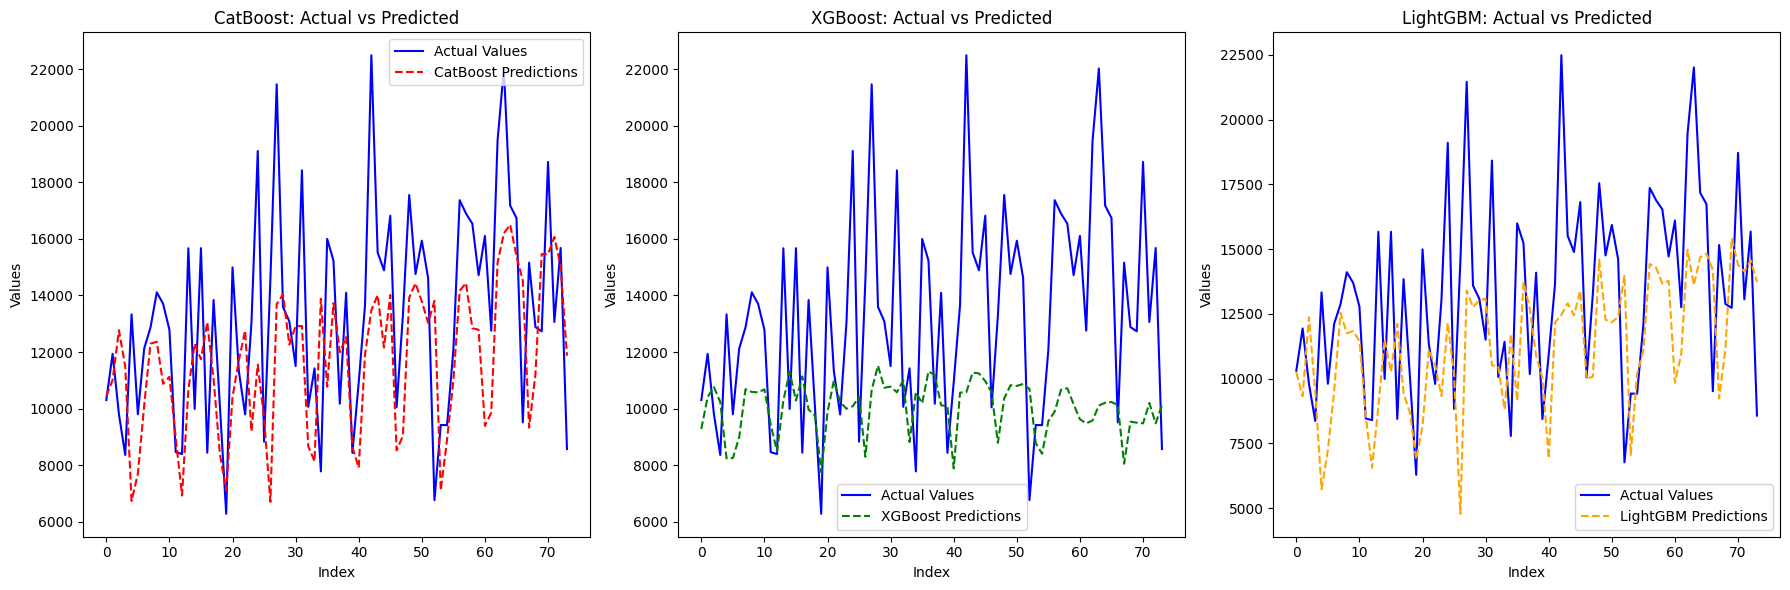

In [285]:
plt.figure(figsize=(18, 6))

# Plot for CatBoost
plt.subplot(1, 3, 1)
plt.plot(y_test.values, label='Actual Values', color='blue')
plt.plot(y_pred_catboost, label='CatBoost Predictions', color='red', linestyle='--')
plt.title('CatBoost: Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Plot for XGBoost
plt.subplot(1, 3, 2)
plt.plot(y_test.values, label='Actual Values', color='blue')
plt.plot(y_pred_xgb, label='XGBoost Predictions', color='green', linestyle='--')
plt.title('XGBoost: Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Plot for LightGBM
plt.subplot(1, 3, 3)
plt.plot(y_test.values, label='Actual Values', color='blue')
plt.plot(y_pred_lgbm, label='LightGBM Predictions', color='orange', linestyle='--')
plt.title('LightGBM: Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

We can see that CatBoost predictions look nicer than others. Now the model catches lower sales better than in previous dataset. However, the issue of not predicting higher sales correctly remains.

For now the notebook is alreagy too big, and hyperparameter tuning and model selection will remain the same for other datasets, so there is no point on focusing on this. I think it's better to dive into other issues and their possible solution of the data.

## Next Steps

Here are the possible next steps of this project:
* Collect more relevant data that can help to make predictions
* Get a model for every dataset
* Make predictions for all nodes in the hierarchy
* Organize everything, that is done, to a single pipeline
* Try reconciliation techniques, if higher level predictions are of importance
* Put some work in model improvement

Some of these steps are obvious, on others I want to focus.

- Collect more data. I will get to it in the next section.
- Model improvement. We have seen a clear disadvantage of the models: they underestimate higher sales and overestimate lower. There are 2 techniques that we can use to fix the issue:
    1. Scaling data. Log or min-max transformations can fix the distribution of data and make models more precise.
    2. Calibrated predictions. Use other algorithms to align predictions closer with true values.

Let's try the first option.

In [286]:
train_data_sc = train_dfs['cucumber_shop1'].copy()
test_data_sc = test_dfs['cucumber_shop1'].copy()

In [288]:
train_data_sc['sales_log'] = np.log1p(train_data_sc['sales'])
test_data_sc['sales_log'] = np.log1p(test_data_sc['sales'])

catboost_param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

tscv = TimeSeriesSplit(n_splits=5)

catboost = CatBoostRegressor(early_stopping_rounds=50, verbose=0)

# Set up Randomized Search
random_search_catboost = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=catboost_param_grid,
    n_iter=10,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42
)

X_train = train_data_sc.drop(['sales', 'sales_log', 'date', 'shop_id'], axis=1)
y_train_log = train_data_sc['sales_log']
random_search_catboost.fit(X_train, y_train_log)

# Get the best estimator
best_catboost = random_search_catboost.best_estimator_

# Make predictions with the best model
X_test = test_data_sc.drop(['sales', 'sales_log', 'date', 'shop_id'], axis=1)
y_test = test_data_sc['sales']
y_pred_log = best_catboost.predict(X_test)

# Inverse transform the predictions to the original scale
y_pred = np.expm1(y_pred_log)

# Evaluate the model
mae_catboost = mean_absolute_error(y_test, y_pred)
print(f'CatBoost MAE: {mae_catboost}')

CatBoost MAE: 1044.6160433757757


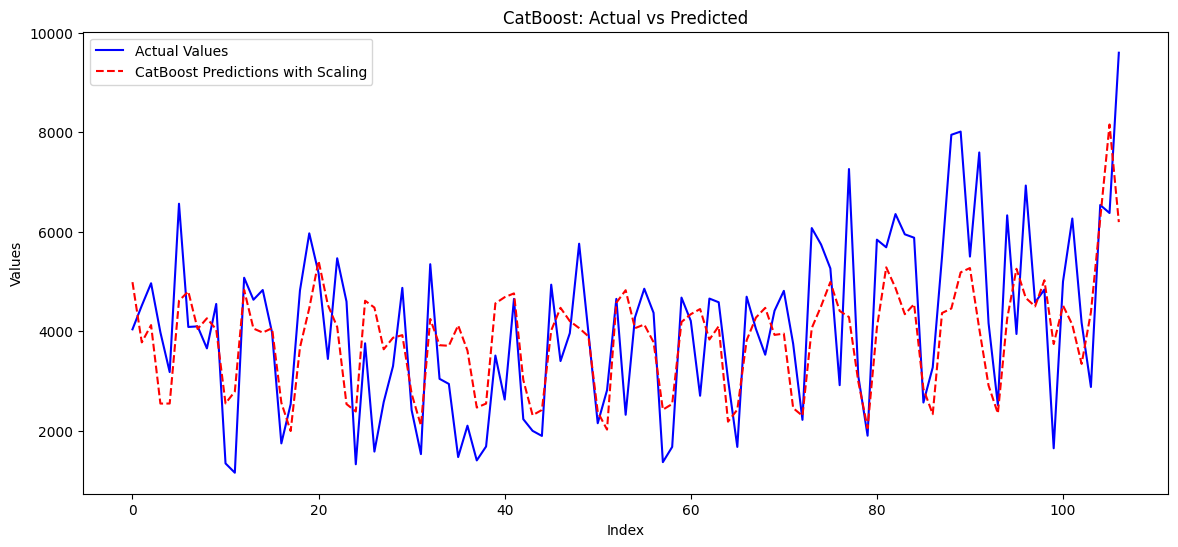

In [289]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual Values', color='blue')
plt.plot(y_pred, label='CatBoost Predictions with Scaling', color='red', linestyle='--')
plt.title('CatBoost: Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

Well, it looks a bit better than before.

Here I finish with practical part of this assignment and move to theoretical questions.

# Questions

## Which features do you think are the most important ones?

As we've seen before, promotion and price have a high influence on a target variable. So, from initial dataframe these features are the most important.

Lag features are also important, but differently for each dataframe.

We can also assume that day of week is an important feature, because sales depend on it.

Now let's see what feature importances have our last model.

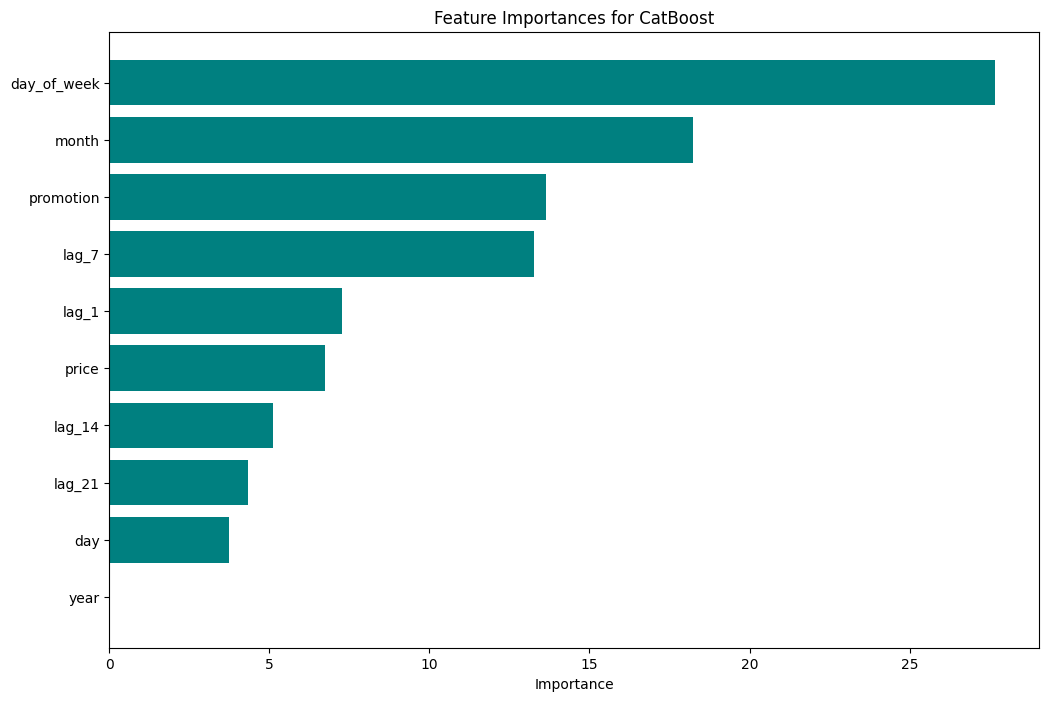

In [290]:
importances = best_catboost.get_feature_importance()
features = X_train.columns

# Create a DataFrame for feature importances
importances_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='teal')
plt.xlabel('Importance')
plt.title('Feature Importances for CatBoost')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

Well, day of week is by far the most imoprtant feature for this dataset.

Surprisingly, month is also an important feature.

Lag_7 is the most important lag. It also make sense because this lag has a relatioship with the day of week.

Promotion has more influence than price. I think it is more of a psychological influence. Also, these features contain some amount of multicollinearity. It may be a good idea to remove price then.

Year does not influence at all because we have only 1 year for this dataset.

## What additional data would you need to improve the model?


Other important features can be:
* Weather at that day: it influences the number of people who came to the shop
* Location of a store: it influences how much people are using the store
* If there are some special days in the shop(Black Friday): also, more people are coming in general and buy a particular item
* Rolling statistics: same as lag features but show the latest trend

## In your opinion do the provided data contain enough observations for this task?

I think that it would be nice to have the data for bigger time period. First, it will add more long term trend to the model. Second, it will improve testing because we will be able to test the model on the same period of the next year, like we did with Bakery but were not able with Vegetables.